# Programmieren 2 Projekt Diabetes Health Indicators (Gruppe 7)

# 0. Vorbereitung

## 0.1 externe Bibliotheken installieren

In [36]:
# %pip install missingno
# %pip install tensorflow

## 0.2 Bibliotheken, Funktionen und Klassen importieren

In [33]:
# Bibliotheken
import base64
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Allgemein
from sklearn.pipeline import make_pipeline, Pipeline

# Feature Selection
# from scipy import stats
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, chi2, mutual_info_classif

# Feature Scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Datensatz aufsplitten
from sklearn.model_selection import StratifiedKFold, KFold

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.multiclass import OneVsOneClassifier
# from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import cross_val_score

## 0.3 Datensatz aus OneDrive einlesen
Der Datensatz wird aus OneDrive eingelesen. 

*Quelle: https://towardsdatascience.com/onedrive-as-data-storage-for-python-project-2ff8d2d3a0aa*

In [2]:
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

df = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1FNrZ1ho6d2NZqUV?e=MDLRDb"),sep=",", engine="python")
# df_large = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1RKf3ExkvP3fLF0q?e=N106Gb"),sep=",", engine="python")

# 1. Business Understanding

## 1.1 Problemstellung

## 1.2 Ziel des Projekts

## 1.3 Kritische Faktoren

# 2. Data Understanding

In [165]:
# print(df_large.shape)
# print(df_large.columns)

## 2.1 Variablen und Skalenniveaus

Die Erklärung der Variablen des Datensatzes sind in der Beschreibung auf Kaggle bzw. in den Kommentaren zu finden. Zur Validierung der in Kaggle angegebenen Dokumentation kann der "Codebook Report" des Behavioral Risk Factor Surveillance System aus dem Jahr 2015 verwendet werden. Dieser beinhaltet eine Beschreibung des unbereinigten Datensatzes mit mehr als 300 Features. Da die Features beim Bereinigen zum Teil umbenannt wurden, ist es hilfreich, das Jupyter Notebook, das für die Bereinigung des großen Datensatzes erstellt wurde und auf Kaggle zu finden ist, hinzuzuziehen.

Link zum Datensatz (Kaggle): *https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset*

2015 Codebook Report (BRFSS): *https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf*

Link zum unbereinigten Datensatz: *https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system*

Link zum Jupyer Notebook zur Bereinigung: *https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook*

In [166]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

### 2.1.1 Features

#### demographische Features:
**Sex**: nominalskaliert (kategorisch); 0 = weiblich, 1 = männlich

**Age**: ordinalskaliert (kategorisch); 1 = 18-24 Jahre alt, 2 = 25-29 Jahre alt, 3 = 30 bis 34 Jahre alt, 4 = 35 - 39 Jahre alt, 5 = 40 bis 44 Jahre alt, 6  = 45 - 49 Jahre alt, 7 = 50 - 54 Jahre alt, 8 = 55 - 59 Jahre alt, 9 = 60 - 64 Jahre alt, 10 = 65 - 69 Jahre alt, 11 = 70 - 74 Jahre alt, 12 = 75 - 79 Jahre alt, 13 = 80 oder älter

**Education**: ordinalskaliert (kategorisch); 1 = Kindergarten, 2 = Grundschule (Elementary School, Grade 1 through 8), 3 = Some High School  (Grade 9 through 11), 4 = High School Degree (Grade 12 or GED), 5 = College 1 year to 3 years (Some college or technical school), 6 = College 4 Years or more (College graduate)

**Income**: ordinalskaliert (kategorisch); 1 = < 10000 USD Einkommen, 2 = 10000 - 15000 USD , 3 = 15000 - 20000 USD, 4 = 20000 - 25000 USD, 5 = 25000 - 35000 USD, 6 = 35000 - 50000 USD, 7 = 50000 - 75000 USD, 8 = 75000+ USD

#### medizinische Features:
**HighBP**: nominalskaliert (kategorisch); 0 = kein hoher Blutdruck, 1 = hoher Blutdruck

**HighCol**: nominalskaliert (kategorisch); 0 = kein hoher Cholesterinspiegel, 1 = hoher Cholesterinspiegel

**CholCheck**: nominalskaliert (kategorisch); 0 = kein Cholesterincheck in den letzten 5 Jahren, 1 = Cholesterincheck in den letzten 5 Jahren

**HeartDieseaseorAttack**: nominalskaliert (kategorisch); 0 = keine Herzkrankheit oder Herzinfarkt, 1 = Herzkrankheit oder Herzinfarkt

**BMI**: intervallskaliert (numerisch), [kg/m²]

**Stroke**: nominalskaliert (kategorisch); 0 = noch keinen Schlaganfall gehabt, 1 = Schlaganfall gehabt 

**AnyHealthCare**: nominalskaliert (kategorisch); 0 = keine Krankenversicherung, 1 = Krankenversicherung (bezogen auf USA)

**NoDocbcCost**: nominalskaliert (kategorisch); 0 = konnte in den letzten 12 Monaten immer zum Doktor gehen, 1 = in den letzten 12 Monaten 
Doktor gebraucht aber nicht leisten können (bezogen auf USA)

**GenHlth**: ordinalskaliert (kategorisch); genereller Gesundheitsstatus: 1 = exzellent, 2 = sehr gut, 3 = gut, 4 = in Ordnung, 5 = schlecht

**MenHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem mental nicht gut ging (Stress, Depression, emotionale Probleme) 

**PhysHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem körperlich nicht gut ging (körperliche Krankheit, Verletzung)

**DiffWalk**: nominalskaliert (kategorisch); 0 = keine Schwierigkeiten beim Laufen, 1 = Schwierigkeiten beim Laufen

#### "Lifestyle" Features:

**PhysActivity**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen man körperlich aktiv war

**Fruits**: nominalskaliert (kategorisch); 0 = isst weniger als eine Frucht pro Tag, 1 = isst eine oder mehr Früchte pro Tag

**Veggies**: nominalskaliert(kategorisch); 0 = isst weniger als ein Gemüse pro Tag, 1 = isst eine oder mehr Gemüse pro Tag

**HvyAlcoholConsump**: nominalskaliert (kategorisch); 0 = weniger als 14 Drinks (7 bei Frauen) pro Woche, 1 = mehr als 14 Drinks (7 bei Frauen) pro Woche

**Smoker**: nominalskaliert (kategorisch); 0 = nicht mehr als 100 Zigaretten im Leben geraucht, 1 = mehr als 100 Zigaretten im Leben geraucht

### 2.1.2 Target

**Diabetes_012**: ordinalskaliert (kategorisch); 0 = gesund, 1 = prediabetes, 2 = diabetes

## 2.1.3 Variablen umbenennen

Die meisten Variablen des Datensatzes werden bereits durch ihre Namen ausreichend erklärt. Trotzdem gibt es ein paar Variablen, bei denen es zum vollständigen Verständnis der Bedeutung noch einer zusätzlichen Erläuterung bedarf. Diese werden direkt zu Beginn passend umbenannt, damit später im Code, nach der Umbennenung, keine Probleme auftreten.

In [3]:
df.rename(columns = {'Diabetes_012': 'Diabetes_Type', 'Sex': 'Sex_male'}, inplace = True)
df.columns

Index(['Diabetes_Type', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex_male', 'Age', 'Education',
       'Income'],
      dtype='object')

Es ist zu erkennen, dass die Zielvariable 'Diabetes_012' zu 'Diabetes_Type' umbenannt wurde. Darüber hinaus heißt das Feature, dass das Geschlecht eines Patienten beinhalten nun 'Sex_male', wobei der Patient männlich ist, wenn der Wert der Variable 1 (True) ist.  

## 2.2 Einblick in den  Datensatz

### 2.2.1 grundlegende Informationen über den Datensatz

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_Type         253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### 2.2.1 Anzeige der ersten Zeilen

In [169]:
pd.set_option('display.max_columns', None)
df.head()

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 2.2.2 Anzeige der letzten Zeilen

In [170]:
# df.tail()

### 2.2.3 Größe des Datensatzes

In [171]:
print(f'Der Datensatz hat {df.shape[0]} Zeilen und {df.shape[1]} Spalten.')

Der Datensatz hat 253680 Zeilen und 22 Spalten.


### 2.2.4 Anzahl der einzigartigen Werte pro Feature

In [172]:
df.nunique()

Diabetes_Type            3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex_male                 2
Age                     13
Education                6
Income                   8
dtype: int64

## 2.3 Deskriptive Statistik im Datensatz

In [173]:
df.describe()

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


## 2.4 Klassenverteilung im Datensatz bezüglich der Zielvariable

In [174]:
Diabetes_valuecount = df['Diabetes_Type'].value_counts()
Diabetes_valuecount

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes_Type, dtype: int64

### 2.4.1 Visualisierung - Klassenverteilung im Datensatz

Zur Visualisierung der Klassenverteilung im Datensatz bezüglich der Targetvariable 'Diabetes_012' wird im Folgenden ein **Pieplot** mittels der pie()-Funktion aus der matplotlib-library erstellt.

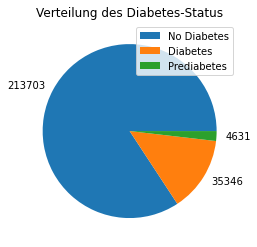

In [175]:
%matplotlib inline
labels = ['No Diabetes', 'Diabetes', 'Prediabetes']
plt.pie(Diabetes_valuecount, labels=Diabetes_valuecount)
plt.legend(labels)
plt.title('Verteilung des Diabetes-Status')
plt.show()

### 2.4.2 Ergebnis (absolute Werte) - Klassenverteilung im Datensatz 
Der Datensatz ist **unausgewogen**. Das bedeutet, dass eine Klasse des Datensatzes gegenüber den anderen deutlich über-/unterrepräsentiert ist.

213703 Personen im Datensatz haben kein Diabetes, 4631 Personen haben Pre-Diabetes, und 35346 Personen haben Diabetes.

### 2.4.3 Ergebnis (prozentualer Anteil) - Klassenverteilung im Datensatz

In [176]:
# df_diab_val_count = Diabetes_valuecount.to_frame(name='absolute Werte')
# df_diab_val_count['prozentual'] = df_diab_val_count['absolute Werte']/ df_diab_val_count.shape[0]
# df_diab_val_count

In [177]:
# Funktion zur Berechnung der prozentualen Klassenverteilung im Datensatz

def calc_prozentual_target(df):
    # Shape 
    df_diab0 = df.loc[df['Diabetes_Type'] == 0.0]
    df_diab1 = df.loc[df['Diabetes_Type'] == 1.0]
    df_diab2 = df.loc[df['Diabetes_Type'] == 2.0]

    df_diab0_count = df_diab0.shape[0]
    df_diab1_count = df_diab1.shape[0]
    df_diab2_count = df_diab2.shape[0]

    df_diab0_perc = round((df_diab0_count/df.shape[0])*100, 3)
    df_diab1_perc = round((df_diab1_count/df.shape[0])*100, 3)
    df_diab2_perc = round((df_diab2_count/df.shape[0])*100, 3)
    
    diabetes_perc_list = [df_diab0_perc, df_diab1_perc, df_diab2_perc]
    
    return diabetes_perc_list

In [178]:
diabetes_perc_df = calc_prozentual_target(df)

print(f'Der vollständige Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten, {diabetes_perc_df[1]} % Patienten mit Prediabetes und {diabetes_perc_df[2] }% Patienten mit \nDiabetes.')

Der vollständige Datensatz enthält 84.241 % gesunde Patienten, 1.826 % Patienten mit Prediabetes und 13.933% Patienten mit 
Diabetes.


## 2.5 Fehlende Werte

Zur Visualisierung möglicher fehlender Werte im Datensatz wird eine **Missing-Data-Matrix** mithilfe der missingno-Bibliothek erstellt. Diese besteht aus schwarzen Balken für die jeweiligen Variablen. Mögliche fehlende Werte wären durch weiße Striche in den Balken gekennzeichnet.

##### Visualisierung - Fehlende Werte

<AxesSubplot:>

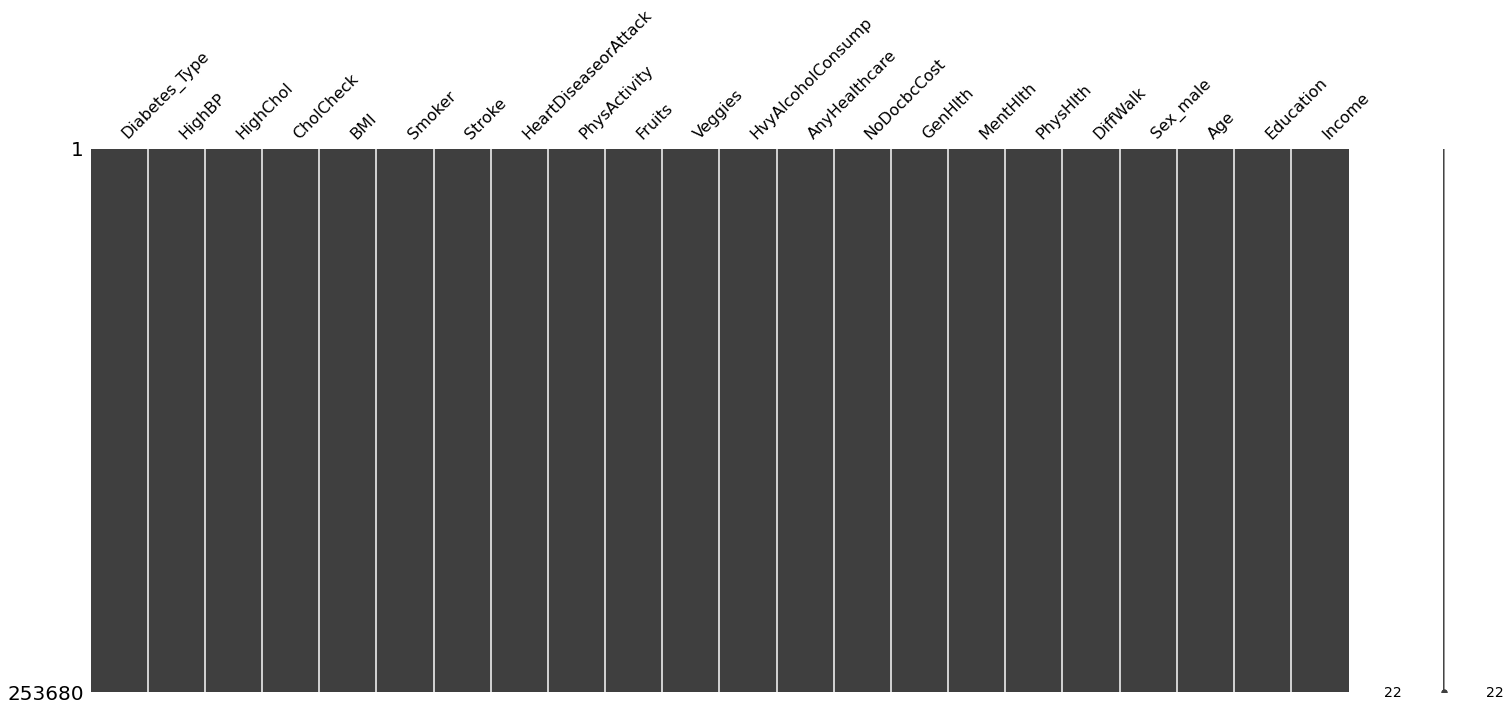

In [179]:
%matplotlib inline
msno.matrix(df)

##### Ergebnis - Fehlende Werte

In [180]:
print(f'Der Datensatz enthält {df.isnull().sum().sum()} fehlende Werte.')

Der Datensatz enthält 0 fehlende Werte.


Dies ist bereits in der Infotabelle unter Kapitel 2.2.1 zu erkennen, da bei keiner Variable die Anzahl von "non-null"-Werten von der Gesamtgröße des Datensatzes abweicht. In Kapitel 2.5.1 wird dies durch die graphische Veranschaulichung nochmals bestätigt. 

Da es sich beim Datensatz um einen bereits bereinigten Datensatz handelt, war dies bereits zu erwarten. Aufgrund der Vollständigkeit des Datensatzes ist eine weitere Behandlung möglicher fehlender Werte in Kap. 3 (Data Preparation) überflüssig.  

## 2.6 Explorative Analyse des Datensatzes

### 2.6.1 Visualisierung mit Boxplots
Um eine erste Idee vom Datensatz und möglichen **Ausreißern** bei den Features zu bekommen, wird jeweils ein **Boxplot** für jede nicht binäre Variable erstellt. Die Voraussetzung, um einen Boxplot berechnen zu können, ist eine Variable, die **mindestens Ordinalskalen-Niveau** hat. Zur Erstellung der Boxplots wird die boxplot()-Funktion aus der seaborn-library verwendet.

*https://www.statistikpsychologie.de/boxplot/#:~:text=Die%20Voraussetzung%2C%20um%20einen%20Boxplot,den%20Skalenniveaus%20findest%20du%20hier)*

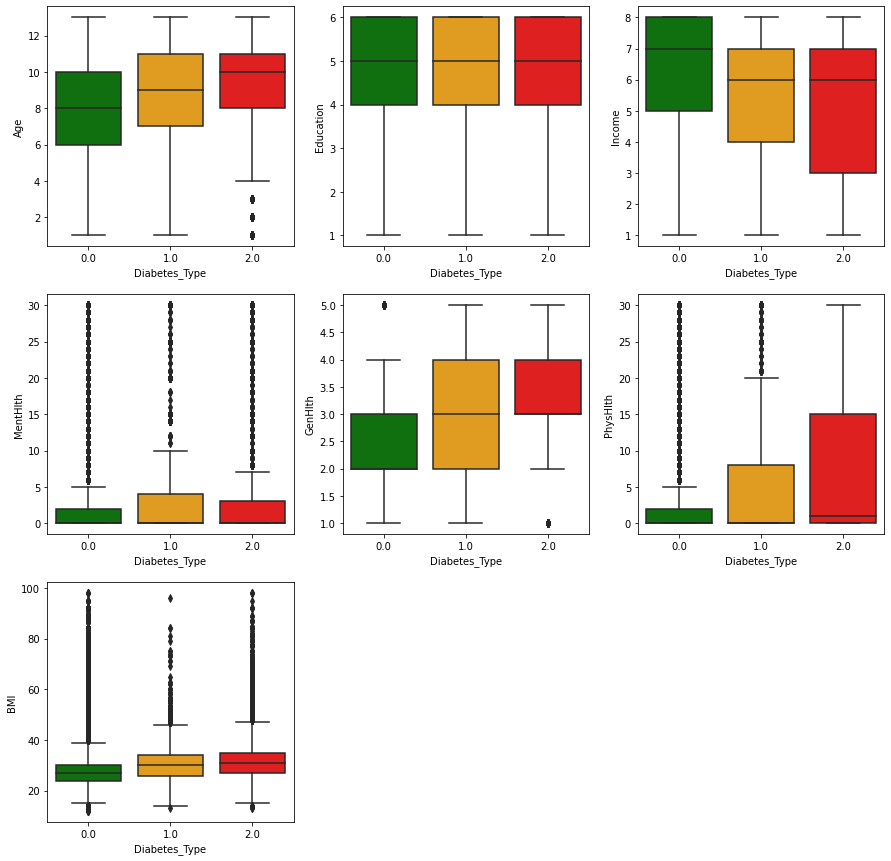

In [181]:
%matplotlib inline

features_boxplots = ['Age', 'Education', 'Income', 'MentHlth', 'GenHlth', 'PhysHlth', 'BMI']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_boxplots:
    sns.boxplot(ax=axes[row_count, col_count], data=df, x='Diabetes_Type', y=feature, palette=['Green', 'Orange', 'Red'])
    col_count += 1
    if col_count > 2:
        row_count += 1
        col_count = 0

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

##### Interpretation - Boxplots

In [182]:
# Erklärung, warum bei manchen Boxplots der Median nicht eingezeichnet ist

### 2.6.2 Visualisierung mit Säulendiagrammen
Zur Darstellung der Verteilung der **nominalskalierten** Variablen werden im Folgenden einige Säulendiagramme erstellt.

In [183]:
# Funktion zur Berechnung der bedingten Wahrscheinlichkeiten des Diabetes-Status unter bestimmten Bedingungen 
def create_diabetes_feature_tab(feature):
    # DataFrame erstellen, der die Anzahl aller Zugehörigen eines Features unter der Bedinungen des Diabetes-Status enthält 
    diabetes_feature_count = df.groupby(['Diabetes_Type', feature]).size().reset_index(name = 'Count')
    # DataFrame erstellen, der die Anzahl aller Zugehörigen zum jeweiligen Diabetes-Typ enthält
    diabetes_count_total = diabetes_feature_count.groupby(['Diabetes_Type']).sum().Count
    # gerade erstellte DataFrames zusammenfügen
    diabetes_feature_count_tab = diabetes_feature_count.set_index('Diabetes_Type').join(diabetes_count_total,rsuffix='_Diabetes')
    # neue Spalte hinzufügen, die prozentualen Anteil von Personen einer Featureausprägung in Bezug auf jeweiligen Diabetestyp enthält
    diabetes_feature_count_tab['Percentage'] = diabetes_feature_count_tab['Count']/diabetes_feature_count_tab['Count_Diabetes']
    # Indizes des DataFrames zurücksetzen
    diabetes_feature_count_tab.reset_index(inplace = True)
    # Antworten leichter verständlich machen
    diabetes_feature_count_tab['Diabetes_Type'].replace({0.0: 'Healthy', 1.0: 'Prediabetes', 2.0: 'Diabetes'}, inplace=True)
    diabetes_feature_count_tab[feature].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
    return diabetes_feature_count_tab

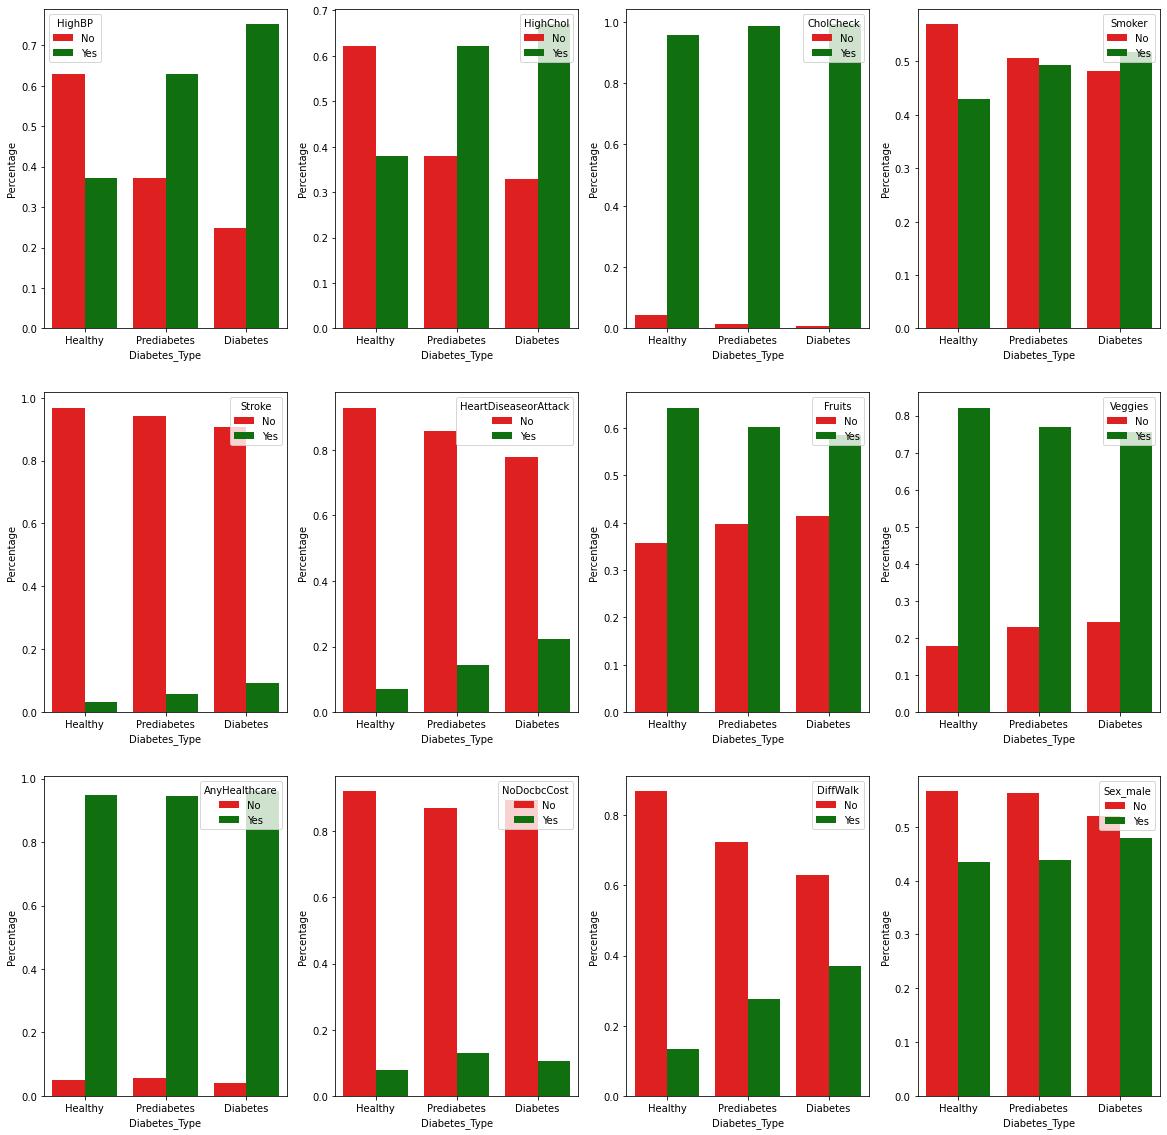

In [184]:
features_barplots = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'Fruits', 'Veggies', 
                     'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex_male']

fig, axes = plt.subplots(3, 4, figsize=(20,20))

row_count = 0
col_count = 0

for feature in features_barplots:
    diabetes_feature_count_tab = create_diabetes_feature_tab(feature)
    sns.barplot(x='Diabetes_Type', y='Percentage', hue=feature, data=diabetes_feature_count_tab, ax=axes[row_count, col_count], palette=['Red','Green'])
    # axes[row_count, col_count].title('Diabetes vs. ' + str(feature))
    col_count += 1
    if col_count > 3:
        row_count += 1
        col_count = 0

### 2.6.3 Visualisierung mit kde-Plots

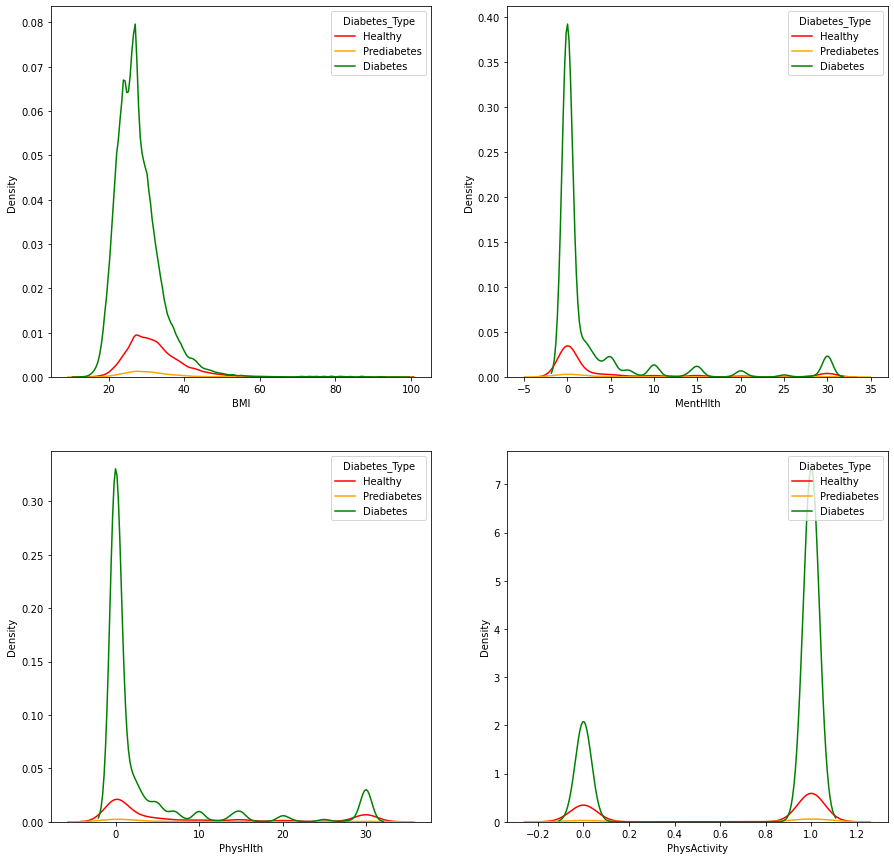

In [185]:
features_kdeplot = ['BMI', 'MentHlth', 'PhysHlth', 'PhysActivity']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_kdeplot:
    sns.kdeplot(ax=axes[row_count, col_count], data=df, x=feature, hue='Diabetes_Type', palette=['Green', 'Orange', 'Red'], legend=False)
    axes[row_count,col_count].legend(title='Diabetes_Type', loc='upper right', labels=['Healthy', 'Prediabetes', 'Diabetes'])
    col_count += 1
    if col_count == 2:
        row_count += 1
        col_count = 0
      
plt.show()

### 2.6.4 Nähere Betrachtung einiger Features

#### 2.6.4.1 High Cholesterol vs. Cholesterol Check

In [186]:
# sns.barplot(x='HighChol', hue='CholCheck', data=df)
# distplot
# Plot Age vs. Gender

## 2.7 statistische Zusammenhänge zwischen den Variablen

### 2.7.1 Zusammenhang zwischen numerischen Inputs und kategorischem Output

#### 2.7.1.1 Kendall'scher Rangkorrelationskoeffizient

C:\Users\Max\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


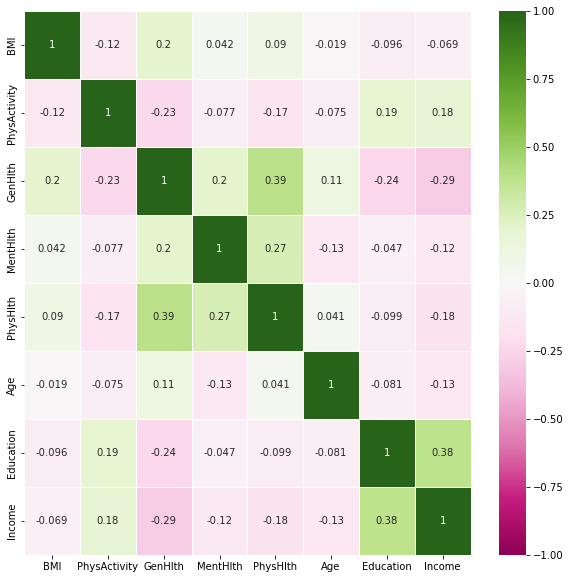

In [187]:
df_ordinal_or_more = df[['BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']]

fig = plt.figure(figsize=(10,10))
# sns.heatmap(df_ordinal_or_more.corr(method='kendall'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True, linewidths=1)
sns.heatmap(df_ordinal_or_more.corr(method='kendall'), vmin=-1, vmax=1, cmap='PiYG', annot=True, linewidths=1)
plt.show()

#### 2.7.1.2 Analysis of Variance (ANOVA)

### 2.7.2 Zusammenhang zwischen kategorischen Inputs und kategorischem Output

In [188]:
# Erklärung welche Methoden hierfür verwendet werden dürfen

In [189]:
# kategorisch = kategorial?

#### 2.7.2.1 Chi-Quadrat-Test

In [190]:
# Erklärung zum Chi-Quadrat-Test einfügen, kurz beschreiben warum Heatmap gewählt wurde
# Skalenniveaus überprüfen

In [191]:
categorical_features_list = ['Diabetes_Type', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk',
                       'Sex_male', 'Age', 'Education', 'Income']

chisqmatrix = pd.DataFrame(columns=categorical_features_list, index=categorical_features_list)

for i in categorical_features_list:
    for j in categorical_features_list:
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1,1), np.array(df[j]).reshape(-1,1))
            chisqmatrix.loc[i, j] = p_val
        else:
            chisqmatrix.loc[i, j] = 0.0

##### Visualisierung - Chi-Quadrat-Test

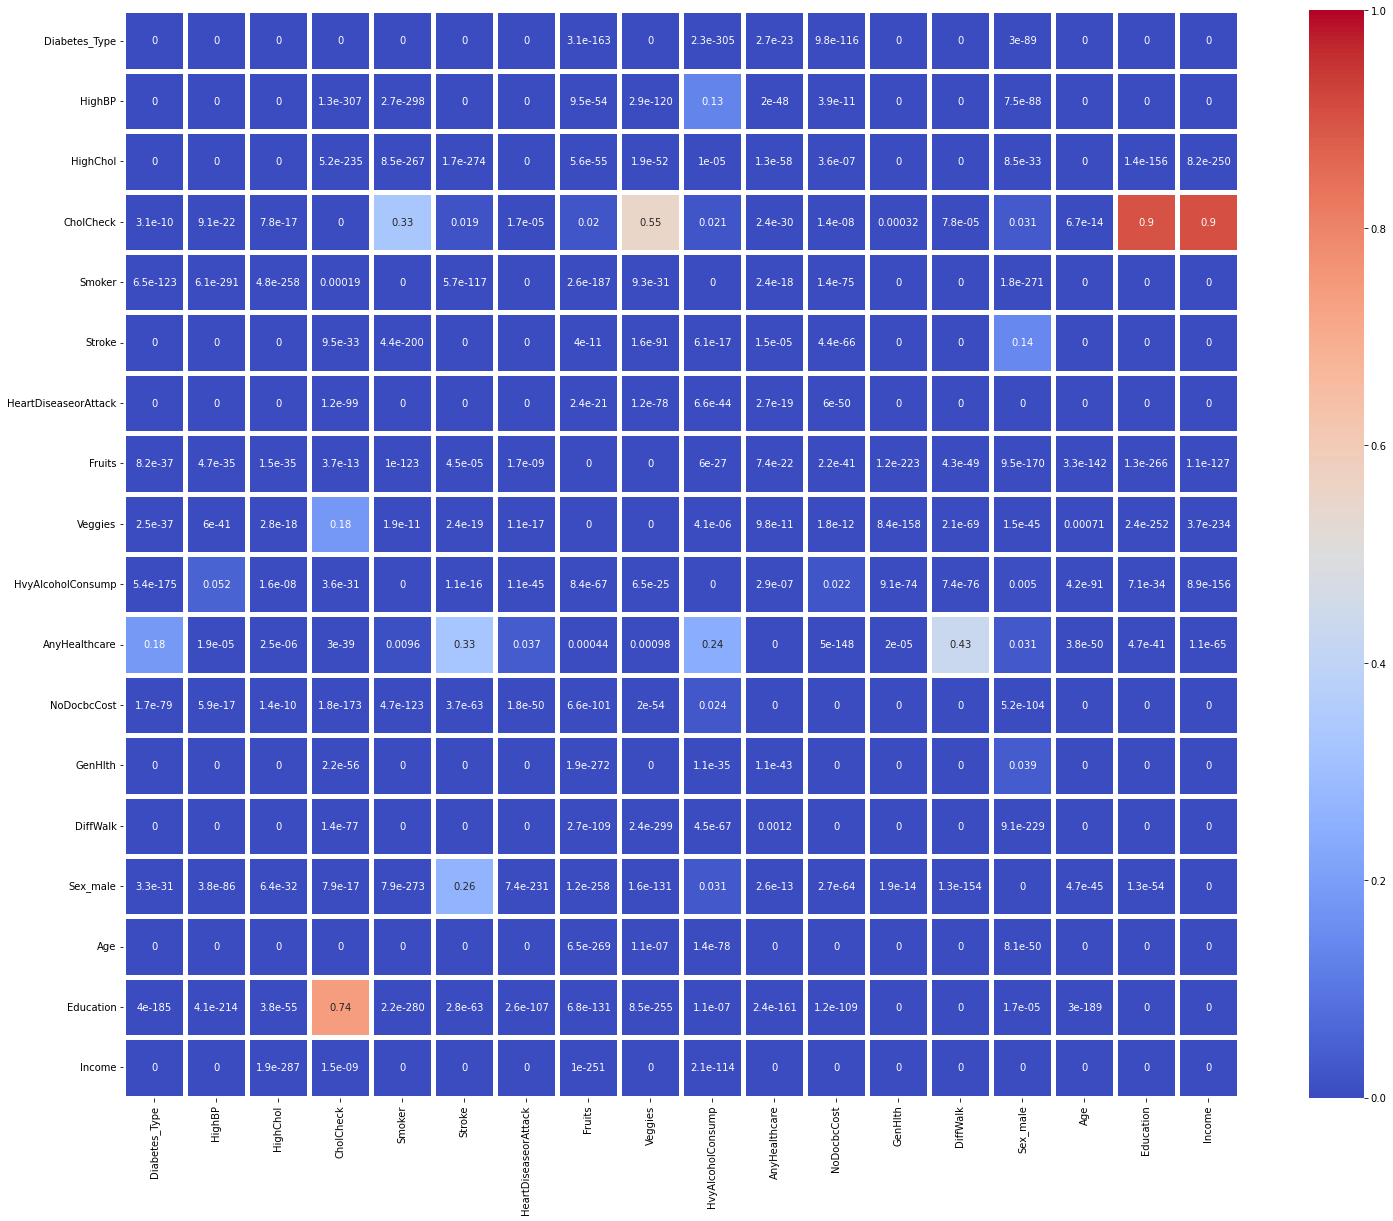

In [192]:
fig = plt.figure(figsize=(25,20))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True, linewidths=5, vmin=0, vmax=1, cmap='coolwarm')
plt.show()

In [193]:
# chi2(np.array(df['HighChol']).reshape(-1,1), np.array(df['CholCheck']).reshape(-1,1))

##### Interpretation - Chi-Quadrat-Test

In [30]:
# viele niedrige Werte wegen großer Stichprobenanzahl (s. Datatab)

##### Quellen zum Code (Chi-Quadrat-Test) 
*https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f*
*https://www.analyticsvidhya.com/blog/2021/06/decoding-the-chi-square-test%E2%80%8A-%E2%80%8Ause-along-with-implementation-and-visualization/*

##### weitere Quellen (Chi-Quadrat-Test)
*https://datatab.de/tutorial/chi-quadrat*

# 3. Data Preparation

In [195]:
# evtl. Variante einfügen, in der BMI, PhysActivity, PhysHlth, MentHlth nochmals gruppiert sind --> Sensititvitätsanalyse
# evtl. auch binäre Klassifikation testen (Nein = 0.0, Ja = 1.0+2.0)

## 3.1 Data Cleaning

### 3.1.1 Duplikate entfernen

Im Bereich des Machine Learnings können **doppelte Feature Vektoren** aus verschiedenen Gründen **problematisch** werden. Fällt zum Beispiel eine Zeile nach dem Split in den Trainingsdatensatz und die andere, gleiche Zeile in den Testdatensatz, so hat das Modell diese Daten bereits gesehen. Hierdurch wird das anschließende Ergebnis verzerrt. (*https://deepchecks.com/what-is-data-cleaning/*) Hierbei könnten doppelte Zeilen im Datensatz zu **Overfitting** führen, wenn das Modell mehrmals mit den gleichen Daten trainiert wird. Um dies zu verhindern werden die Duplikate aus dem "Diabetes Health Indicators" Datensatz ausfindig gemacht und **entfernt**.

In [4]:
# Anzahl der Zeilen im unbereinigten Datensatz
print(f'Der unbereinigte Datensatz umfasst {df.shape[0]} Feature Vektoren.')

Der unbereinigte Datensatz umfasst 253680 Feature Vektoren.


In [5]:
duplicates = df[df.duplicated()]
print(f'Davon sind {len(duplicates)} Zeilen doppelt.')

Davon sind 23899 Zeilen doppelt.


In [6]:
# Ausgabe der doppelten Zeilen
duplicates

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
1242,2.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,2.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


In [7]:
# doppelte Zeilen werden entfernt
df.drop_duplicates(inplace = True)

In [8]:
# Anzahl der Zeilen im bereinigten Datensatz
print(f'Der bereinigte Datensatz beinhaltet noch die Daten von {df.shape[0]} Patienten.')

Der bereinigte Datensatz beinhaltet noch die Daten von 229781 Patienten.


In [201]:
df_dup_removed_diab_perc_list = calc_prozentual_target(df)

print(f'Der bereinigte Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten, {diabetes_perc_df[1]} % Patienten mit Prediabetes und {diabetes_perc_df[2] }% Patienten mit \nDiabetes.')

Der bereinigte Datensatz enthält 84.241 % gesunde Patienten, 1.826 % Patienten mit Prediabetes und 13.933% Patienten mit 
Diabetes.


##### Zusammenfassung - Doppelte Zeilen entfernen

Obwohl die Unbalanciertheit des Datensatzes durch das Entfernen der doppelten Zeilen etwas vergrößert wird, sprechen unter anderem die oben genanneten Gründe dafür, sie zur weiteren Bearbeitung aus dem Datensatz zu entfernen. 

### 3.1.2 Unplausible Werte

Aus dem unteren Boxplot in Kap. 2.5.1 und der Informationstabelle, die in Kap. 2.3 mithilfe von df.describe() erstellt wurde, lässt sich ein Maximalwert des BMI von 98kg/m² erkennen. Da man laut der deutschen Adipositas Gesellschaft bereits ab einem BMI über 40kg/m² unter Adipositas Grad III fällt, sind Werte ab einem BMI über 60kg/m² als kritisch einzustufen. (*https://adipositas-gesellschaft.de/bmi/*)

In [202]:
crit_value_bmi = 60
df_crit_bmi = df.loc[df['BMI'] > crit_value_bmi]
print(f'Der Datensatz beinhaltet {df_crit_bmi.shape[0]} Patienten, deren BMI über einem Wert von 60 kg/m² liegt.')

Der Datensatz beinhaltet 805 Patienten, deren BMI über einem Wert von 60 kg/m² liegt.


Da unser Datensatz relativ viele Feature Vektoren enthält, ist es nicht zwingend notwendig die unklaren BMI-Werte zu ersetzen. Allerdings soll durch ein mögliches Entfernen der entsprechenden Zeilen, die Unbalanciertheit des Datensatzes nicht vergrößert werden. Daher wird im Folgenden kurz die Verteilung der Patienten mit kritischem BMI-Wert bezüglich der Klassen des Targets dargestellt. 

In [203]:
df_crit_bmi['Diabetes_Type'].value_counts()

0.0    617
2.0    171
1.0     17
Name: Diabetes_Type, dtype: int64

In [204]:
# df_crit_bmi_removed_diab = df.drop(df.loc[df['BMI'] > crit_value_bmi])

# crit_bmi_removed_perc = calc_prozentual_target(df_crit_bmi_removed_diab)

# print(f'Der Datensatz ohne Patienten mit kritischem BMI-Wert beinhaltet {crit_bmi_removed_diab_perc[0]} % gesunde Patienten, {crit_bmi_removed_diab_perc[1]} % Patienten mit Prediabetes \nund {crit_bmi_removed_diab_perc[2]} % Patienten mit Diabetes.')

In [205]:
# Sensitivitätsanalyse mit und ohne Patienten mit hohem BMI

## 3.2 Vorbereitung des Modellings

Für anschließende Vorgänge in der Vorbereitung des Modellings und im Modelling selbst kann es nützlich sein, den Datensatz in Features (x-Werte) und Target (y-Wert) aufzuteilen.

In [9]:
x_values = df.drop(['Diabetes_Type'],axis='columns')
y_value = df['Diabetes_Type']

Da im weiteren Verlauf eine erneute Trennung des Datensatzes in x- und y-Werte erforderlich sein kann, z.B. nach der Skalierung, werden im Folgenden zwei Funktionen hierfür implementiert.

In [13]:
def get_x_values(df):
    x_values = df.drop(['Diabetes_Type'], axis='columns')
    return x_values

def get_y_value(df):
    y_value = df['Diabetes_Type']
    return y_value

def get_y_value_binary(df):
    y_value = df['Diabetes']
    return y_value

### 3.2.1 Umgang mit kategorischen Daten

Da ein Machine Learning Algorithmus immer besser mit numerischen Werten arbeiten kann, als mit kategorischen Variablen. Aus diesem Grund müssen kategorische Daten häufig speziell für das Modelling vorbereitet werden, indem die kategorischen Werte in numerische Werte umgewandelt werden. Dies gilt sowohl für die Feature-, als auch für die Targetvariablen. (*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*) 

In [208]:
# OneHotEncoding bei ordinalen Daten?
# Encoding auf Target --> für neuronales Netzwerk?

##### Quellen (Umgang mit kategorischen Daten)
*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*

*https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/*

*https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/*

*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.204. Apress.*

### 3.2.2 Oversampling/ Undersampling

In [209]:
# Sensitivitätsanalyse --> Oversampling+kFold vs. StratifiedKFold

In [15]:
# compute_class_weight --> parameter 'class_weight'

*https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a*

### 3.2.3 Feature Scaling

#### 3.2.3.1 Einführung in das Thema Feature Scaling

Wenn ein Modell mit unskalierten Daten trainiert wird, bei dem einige Features einen (deutlich) größeren Wertebereich haben, als andere, kann es beim Training des Modells dazu führen, dass diese Features einen größeren Einfluss auf den Ausgang des Modells haben. Obwohl ein paar Machine-Learning-Algorithmen, wie z.B. baumbasierte Methoden, auch ohne Feature Scaling auskommen, ist es üblich, diese vor dem Modelling zu skalieren. Dies gilt besonders, wenn man viele verschiedene Machine Learning Algorithmen testen und vergleichen will. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*)

Im Folgenden wird eine Funktion scale_df() implementiert, die einen DataFrame und eine Scaling-Methode entgegen nimmt, und den skalierten Datensatz zurückgibt. Diese wird im Modelling an geeigneter Stelle eingesetzt, um die **Daten zu skalieren**. 

In [210]:
# es gibt verschiedene Methoden zum Skalieren der Features

In [10]:
def scale_df(df, scaler_method):
    scaler = scaler_method
    scaled_data = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
    return df_scaled

#### 3.2.3.2 Vorbereitung - Feature Scaling

Genauso wie es wichtig ist das Modell mit unbekannten Testdaten zu testen, ist es auch wichtig, das Scaling innerhalb des Splits durchzuführen. *(Computing cross-validated metrics, 3.1.1 https://scikit-learn.org/stable/modules/cross_validation.html)* Anderenfalls könnte das Skalieren des gesamten Datensatzes dazu führen, dass Informationen aus dem Datensatz noch vor dem Test in das Modell geraten und das anschließende Ergebnis verzerren.

Im Folgenden wird innerhalb eines ersten Stratified KFold-Splits analysiert, ob verschiedene statistische Werte beim Skalieren der Daten in den verschiedenen Folds voneinander abweichen. Falls das nicht der Fall ist, kann das Scaling trotzdem auf den gesamten Datensatz angewendet werden. Darüber hinaus kann es hilfreich sein, um einen Eindruck über die Güte des gewählten Splits zu erhalten.

In [193]:
# veraltet
def create_df_scaling_cv(x_values, y_value, scaler):
    features = list(x_values.columns)
    df_column_names = ['Feature', 'Split', 'Train_Minima', 'Test_Minima', 'Train_Maxima', 'Test_Maxima']
    df_scaled_values = pd.DataFrame(columns=df_column_names)
    split_counter = 1
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        scaler = scaler
        scaled_train = scaler.fit_transform(X_train)
        scaled_test = scaler.transform(X_test)
        for idx, feature in enumerate(features):
            row_counter = (split_counter-1)*len(features) + idx
            df_scaled_values.at[row_counter, 'Split'] = split_counter
            df_scaled_values.at[row_counter, 'Feature'] = feature
            df_scaled_values.at[row_counter, 'Train_Minima'] = np.amin(scaled_train)
            df_scaled_values.at[row_counter, 'Train_Maxima'] = np.amax(scaled_train)
            df_scaled_values.at[row_counter, 'Test_Minima'] = np.amin(scaled_test)
            df_scaled_values.at[row_counter, 'Test_Maxima'] = np.amax(scaled_test)
        split_counter += 1 
    df_scaled_values.sort_values(by=['Feature', 'Split'], inplace=True)
    return df_scaled_values

def create_df_scaling_cv_feature(x_values, y_value, scaler):
    features = list(x_values.columns)
    df_column_names = ['Feature', 'Split', 'Train_Minima', 'Test_Minima', 'Train_Maxima', 'Test_Maxima']
    df_scaled_values = pd.DataFrame(columns=df_column_names)
    split_counter = 1
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        scaler = scaler
        scaled_train = scaler.fit_transform(X_train)
        scaled_test = scaler.transform(X_test)
        df_scaled_train = pd.DataFrame(scaled_train, columns=features)
        df_scaled_test = pd.DataFrame(scaled_test, columns=features)
        for idx, feature in enumerate(features):
            row_counter = (split_counter-1)*len(features) + idx
            df_scaled_values.at[row_counter, 'Split'] = split_counter
            df_scaled_values.at[row_counter, 'Feature'] = feature
            df_scaled_values.at[row_counter, 'Train_Minima'] = df_scaled_train.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Train_Maxima'] = df_scaled_train.iloc[:, idx].max()
            df_scaled_values.at[row_counter, 'Test_Minima'] = df_scaled_test.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Test_Maxima'] = df_scaled_test.iloc[:, idx].max()
        split_counter += 1 
    df_scaled_values.sort_values(by=['Feature', 'Split'], inplace=True)
    return df_scaled_values

##### Vergleich der Minima und Maxima bei Scaling mit dem MinMaxScaler innerhalb eines StratifiedKFold-Splits

In [194]:
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, MinMaxScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,0.0,0.0,1.0,1.0
39,Age,2,0.0,0.0,1.0,1.0
60,Age,3,0.0,0.0,1.0,1.0
81,Age,4,0.0,0.0,1.0,1.0
102,Age,5,0.0,0.0,1.0,1.0
123,Age,6,0.0,0.0,1.0,1.0
144,Age,7,0.0,0.0,1.0,1.0
165,Age,8,0.0,0.0,1.0,1.0
186,Age,9,0.0,0.0,1.0,1.0
207,Age,10,0.0,0.0,1.0,1.0


In [195]:
# Ungenauigkeiten zwischen den Splits nur bei BMI --> evtl. Ausreißer überprüfen

##### Vergleich der Minima und Maxima bei Scaling mit dem StandardScaler innerhalb eines StratifiedKFold-Splits

In [190]:
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, StandardScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,-2.30018,-2.30018,1.626593,1.626593
39,Age,2,-2.302188,-2.302188,1.628091,1.628091
60,Age,3,-2.300045,-2.300045,1.626194,1.626194
81,Age,4,-2.303353,-2.303353,1.625785,1.625785
102,Age,5,-2.301285,-2.301285,1.625774,1.625774
123,Age,6,-2.304061,-2.304061,1.625728,1.625728
144,Age,7,-2.303872,-2.303872,1.626132,1.626132
165,Age,8,-2.303883,-2.303883,1.626652,1.626652
186,Age,9,-2.304376,-2.304376,1.628045,1.628045
207,Age,10,-2.301088,-2.301088,1.626674,1.626674


#### 3.2.3.3 Interpretation (Vorbereitung - Feature Scaling)

Es ist zu erkennen, dass weder die Minimal-, noch die Maximalwerte der skalierten Daten (sowohl mit dem StandardScaler(), als auch mit dem MinMaxScaler()) bei einem StratifiedKFold-Split mit 10 Folds deutlich voneinander abweichen. Hierdurch ist es möglich, die Daten bereits vor dem Modelling mithilfe des ganzen Datensatzes durchzuführen, ohne dass es zu Verzerrungen des Modells kommt. Ein Grund hierfür könnte beispielsweise der relativ große Umfang des Datensatzes sein. Darüber hinaus kann dies ein erstes Indiz dafür sein, dass der Split (StratifiedKFold mit 10 Folds) an dieser Stelle richtig gewählt wurde.

#### 3.2.3.4 Feature Scaling - Standartisieren mit dem StandardScaler

In [215]:
# Erklärung StandardScaler

In [14]:
x_values_scaled_ss = scale_df(x_values, StandardScaler())

In [216]:
df_scaled_ss = scale_df(df, StandardScaler())
df_scaled_ss

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,-0.449376,1.095675,1.124132,0.205356,1.667220,1.071208,-0.216455,-0.339257,-1.658403,-1.258473,0.508092,-0.254232,0.238745,-0.319852,2.253111,1.879074,1.141300,2.095383,-0.885023,0.295241,-0.987588,-1.381324
1,-0.449376,-0.912679,-0.889575,-4.869594,-0.543101,1.071208,-0.216455,-0.339257,0.602990,-1.258473,-1.968149,-0.254232,-4.188578,3.126450,0.374618,-0.454434,-0.516791,-0.477240,-0.885023,-0.351213,1.026729,-2.337131
2,-0.449376,1.095675,1.124132,0.205356,-0.101037,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,-1.968149,-0.254232,0.238745,3.126450,2.253111,3.434746,2.799391,2.095383,-0.885023,0.295241,-0.987588,1.008193
3,-0.449376,1.095675,-0.889575,0.205356,-0.248391,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,-0.254232,0.238745,-0.319852,-0.564629,-0.454434,-0.516791,-0.477240,-0.885023,0.941695,-1.994746,0.052387
4,-0.449376,1.095675,1.124132,0.205356,-0.690456,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,-0.254232,0.238745,-0.319852,-0.564629,-0.065516,-0.516791,-0.477240,-0.885023,0.941695,0.019571,-0.903420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229776,-0.449376,1.095675,1.124132,0.205356,2.403993,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,0.508092,-0.254232,0.238745,-0.319852,0.374618,-0.454434,0.035906,-0.477240,1.129914,-0.997666,1.026729,0.530290
229777,2.310686,1.095675,1.124132,0.205356,-1.574584,-0.933526,-0.216455,-0.339257,-1.658403,-1.258473,-1.968149,-0.254232,0.238745,-0.319852,1.313865,-0.454434,-0.516791,2.095383,-0.885023,0.941695,-3.001905,-0.903420
229778,-0.449376,-0.912679,-0.889575,0.205356,-0.101037,-0.933526,-0.216455,-0.339257,0.602990,0.794614,-1.968149,-0.254232,0.238745,-0.319852,-1.503875,-0.454434,-0.516791,-0.477240,-0.885023,-1.967347,0.019571,-1.859227
229779,-0.449376,1.095675,-0.889575,0.205356,-0.837810,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,0.508092,-0.254232,0.238745,-0.319852,0.374618,-0.454434,-0.516791,-0.477240,1.129914,-0.351213,0.019571,-2.337131


#### 3.2.3.5 Feature Scaling - Normalisieren mit dem MinMaxScaler

In [217]:
# Erklärung MinMaxScaler

In [218]:
df_scaled_minmax = scale_df(df, MinMaxScaler())
df_scaled_minmax

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714
1,0.0,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000
2,0.0,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000
3,0.0,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286
4,0.0,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229776,0.0,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143
229777,1.0,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571
229778,0.0,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857
229779,0.0,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000


In [219]:
# Wenn bei allen Splits gleiche Feature Selection und Scaling --> Split gut gewählt; kann auf ganzen Datensatz gemacht werden

### 3.2.4 Vorbereitung Sensititvitätsanalyse (binär vs. Multiclass)

Ein interessanter Sachverhalt, der beim Modelling in Kapitel 4 näher betrachtet werden soll, ist eine **Sensitivitätsanalyse** bezüglich der Güte des Modells bei einer **binären Klassifikation** im Vergleich zur Klassifikation der Patienten **in drei Klassen** (gesund, Prädiabetes, Diabetes). Bei der binären Klassifikation werden die zwei Klassen für 'Prediabetes' und 'Diabetes' zusammen gefasst zu 'Diabetes'. In diesem Fall wird also nur unterschieden zwischen **gesund oder krank**. Die Trennung der Klassen könnte auch anders herum erfolgen (Prädiabetes gehört zu gesund), allerdings ist es im Falle von Diabetes besser 'Prädiabetes' als krank einzustufen, da der Patient im Falle eines Lebenswandels hier vielleicht sogar noch gesund werden könnte. 

Da diese Unterscheidung in Kapitel 4 für mehrere Machine Learning Algorithmen getestet wird, wird im Folgenden der binäre Datensatz initialisiert.

In [11]:
df_binary = df
df_binary['Diabetes_Type'] = df_binary['Diabetes_Type'].replace({2:1})
df_binary = df_binary.rename(columns={'Diabetes_Type': 'Diabetes'})

In [12]:
df_binary['Diabetes'].value_counts()

0.0    190055
1.0     39726
Name: Diabetes, dtype: int64

## 3.3 Feature Selection

Ein weiterer wichtiger Schritt, der bereits zu Beginn des Modellings eine Rolle spielen kann ist die Feature Selection. Hierbei versucht man die Features ausfindig zu machen, die den größten Einfluss auf die vorhergesagte Klasse der Targetvariable haben. Dies ist nötig, da eine große Anzahl von Features dazu führen kann, dass das Modell komplexer und schwerer zu interpretieren wird. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.242. Apress.*) Feature Selection wird im Allgemeinen angewendet, um Overfitting zu vermeiden, die Accuracy zu erhöhen, und die Trainingsdauer zu minimieren. (*https://machinelearningmastery.com/feature-selection-machine-learning-python/*) Zur Berechung der Feature Importance stehen einem verschiedene Methoden zur Verfügung. Im Allgemeinen werden zur tatsächlichen Auswahl geeigneter Features mehrere dieser Möglichkeiten durchgeführt und anschließend das Gesamtergebnis interpretiert. Ähnlich wie beim Scaling der Features bietet es sich an, die Feature Selection vorerst im Rahmen eines Splits durchzuführen. Auch dieser Schritt zählt zur Vorbereitung des Modellings und müsste eigentlich ein Unterpunkt von Kapitel 3.2 sein, ist aber so umfangreich, dass er hier ein eigenes Teilkapitel bekommt.

### 3.3.1 Optimale Anzahl an Features

##### binär

In [ ]:
y_value_binary = get_y_value_binary(df_binary)

rfc1 = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv1 = RFECV(estimator=rfc1, cv=cv, scoring='accuracy', min_features_to_select=1, verbose=1)
rfecv1.fit(x_values_scaled_ss, y_value_binary)

print("Optimal number of features : %d" % rfecv1.n_features_)

#### 3.3.1.1 Recursive Feature Elimination with Cross Validation (accuracy)

In [12]:
rfc1 = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv1 = RFECV(estimator=rfc1, cv=cv, scoring='accuracy', min_features_to_select=1)
rfecv1.fit(x_values_scaled_ss, y_value)

print("Optimal number of features : %d" % rfecv1.n_features_)

Optimal number of features : 1


##### Visualisierung (3.3.1.1)

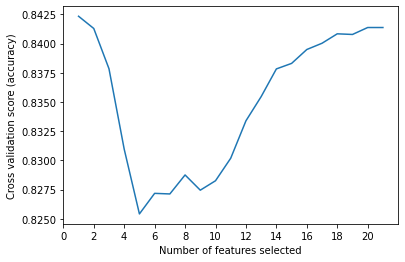

In [13]:
plt.figure()
plt.xticks(np.arange(0, 22, step=2))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv1.grid_scores_) + 1), rfecv1.grid_scores_)
plt.show()

##### Interpretation (3.3.1.1)

Das Ergebnis, das sich aus der Verwendung der Klasse RFECV aus sklearn mit dem scoring-Parameter 'accuracy' ergibt, sieht auf den ersten Blick etwas **unlogisch** aus. Es könnte zum Beispiel an der falschen Wahl des Splits liegen. Allerdings wurde hier aufgrund des unbalancierten Datensatzes absichtlich der StratifiedKFold-Split gewählt. Die Gleichheit der Daten beim Scaling in den einzelnen Folds, aus Kap. 3.2.3.2, deutet aber darauf hin, dass die Wahl des Splits richtig war. Darüber hinaus könnte es an der falschen Wahl für den Estimator-Paramter der RFECV liegen. Allerdings wurde hier RandomForrestClassifier gewählt, da dieser über ein Attribut namens feature_importances_ verfügt und somit für die RFECV geeignet ist. Darüber hinaus liefert er auch bei Multiclassklassifikationen gute Ergebnisse. 

Ein weiterer Punkt, der für die komischen Ergebnissen der RFECV verantwortlich sein könnte, ist die falsche Wahl des scoring-Parameters. Hier wurde der für Klassifikationen geeignete 'accuracy'-Parameter verwendet. Allerdings ist der Parameter **'f1_weighted** speziell für Multiclassklassifikationen mit unbalancierten Datensätzen geeignet. Daher wird im Folgenden versucht, mit diesem Parameter bessere Ergebnisse zu erzielen. (*https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score*)   

#### 3.3.1.2 Recursive Feature Elimination with Cross Validation (f1_weighted)

In [14]:
rfc2 = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv2 = RFECV(estimator=rfc2, cv=cv, scoring='f1_weighted', min_features_to_select=1)
rfecv2.fit(x_values_scaled_ss, y_value)

print("Optimal number of features : %d" % rfecv2.n_features_)

Optimal number of features : 21


##### Visualisierung (3.3.1.2)

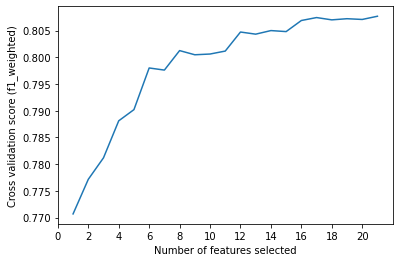

In [16]:
plt.figure()
plt.xticks(np.arange(0, 22, step=2))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_weighted)")
plt.plot(range(1, len(rfecv2.grid_scores_) + 1), rfecv2.grid_scores_)
plt.show()

##### Interpretation (3.3.1.2)

Das Ergebnis für den RFECV mit "f1_weighted" als scoring-Parameter stellt eine **Verbesserung** im Vergleich zum vorherigen Lösungsansatz dar. Zwar wird die optimale Leistung des Algorithmus mit 21 von 21 Features erzielt, allerdings ist in der Visualisierung zu erkennen, dass sich erste lokale Maxima schon bei x=8 bzw. x=13 übrig gebliebenen Features ergeben. Gerade bei nur noch 8 Features hätte sich die Komplexität des Modells und der damit einhergehende Rechenaufwand, bei nur leicht gesunkenen Ergebniswerten, schon deutlich verringert. 

##### Quellen zum Code (Optimale Anzahl an Features)
*https://machinelearningmastery.com/rfe-feature-selection-in-python/*

*https://www.kdnuggets.com/2020/10/feature-ranking-recursive-feature-elimination-scikit-learn.html*

*https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py*

### 3.3.2 Univariate Selection

*https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/*

#### 3.3.2.1 Vorbereitung - Univariate Selection

In [17]:
def univariate_fs_scaling_cv(x_values, y_value, scaler, n_splits, score_func, k):
    print(f'Univariate Feature Selection mit Score-Func {str(score_func)} und Scaler {str(scaler)}')
    features = list(x_values.columns)
    scaler = scaler
    x_values_scaled = scaler.fit_transform(x_values)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    split_counter = 1
    for train_index, test_index in skf.split(x_values_scaled, y_value):
        selected_features_list = []
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        fs = SelectKBest(score_func=score_func, k=k)
        fs.fit(X_train, y_train)
        X_train_fs = fs.transform(X_train)
        X_test_fs = fs.transform(X_test)
        selected_features_bool = fs.get_support()
        features = list(x_values.columns)
        for feature, selected_feature_bool in zip(features, selected_features_bool):
            if selected_feature_bool == True:
                selected_features_list.append(feature)
        print(f'Ausgewählte Features in Split {split_counter}: {selected_features_list}')
        split_counter += 1

#### 3.3.2.2 Auswahl der wichtigsten kategorischen Features

In [11]:
df_categorical_features = df.drop(['BMI', 'MentHlth', 'PhysHlth', 'PhysActivity', 'Diabetes_Type'], axis = 'columns')
target = df['Diabetes_Type']

##### Chi-Quadrat-Test

Zur Berechung der wichtigsten Features mit SelectKBest aus sklearn mit chi2 als score_func, sind keine negativen Werte zulässig. Aus diesem Grund wird an dieser Stelle nicht der StandardScaler() zum Skalieren verwendet, sondern der **MinMaxScaler()**.

In [20]:
univariate_fs_scaling_cv(df_categorical_features, target, MinMaxScaler(), 10, chi2, 6)

Univariate Feature Selection mit Score-Func <function chi2 at 0x0000011D864D30D0> und Scaler MinMaxScaler()
Ausgewählte Features in Split 1: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 2: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 3: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 4: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 5: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 6: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 7: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte Features in Split 8: ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'GenHlth', 'DiffWalk', 'Age']
Ausgewählte 

##### Mutual Info Classification - MinMaxScaler() 

In [21]:
univariate_fs_scaling_cv(df_categorical_features, target, MinMaxScaler(), 10, mutual_info_classif, 6)

Univariate Feature Selection mit Score-Func <function mutual_info_classif at 0x0000011D8682C160> und Scaler MinMaxScaler()
Ausgewählte Features in Split 1: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 2: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 3: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 4: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 5: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 6: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 7: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 8: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte F

##### Mutual Info Classification - StandardScaler()

In [22]:
univariate_fs_scaling_cv(df_categorical_features, target, StandardScaler(), 10, mutual_info_classif, 6)

Univariate Feature Selection mit Score-Func <function mutual_info_classif at 0x0000011D8682C160> und Scaler StandardScaler()
Ausgewählte Features in Split 1: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 2: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 3: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 4: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 5: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 6: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 7: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte Features in Split 8: ['HighBP', 'HighChol', 'CholCheck', 'Veggies', 'AnyHealthcare', 'GenHlth']
Ausgewählte

##### Interpretation - Auswahl der wichtigsten kategorischen Features

Es ist zu erkennen, dass sich weder bei der univariaten Feature Selection mit dem score_func-Parameter 'chi2', noch mit 'mutual info clasification' innerhalb der einzelnen Splits Unterschiede hinsichtlich der bestbewertetsten Features gibt. Lediglich zwischen den einzelnen Wahlen für die Zielfunktion besteht ein geringfügiger Unterschied. Variablen, die zum Beispiel jeweils nur in einer der Methoden vorkommen sind 'HighChol' und 'CholCheck'. Inuitiv betrachtet werden diese Variablen wahrscheinlich miteinander korrelieren. Betrachtet man die Tabelle der p-Werte aus dem chi2-Test in Kap. 2.7.2.1 scheint sich dieser Verdacht zu bestätigen. Da dieser kleiner als 5% ist, kann man hier nämlich die Nullhypothese verwerfen, wodurch statistisch gesehen eine Abhängigkeit zwischen beiden Variablen besteht. Hier könnte also überlegt werden, ob man sich beim Modelling nur für eine der beiden Variablen entscheidet. Variablen wie **'HighBP', 'HighChol', 'GenHlth' und 'Age'** kommen bei beiden Methoden als wichtige Variablen heraus und stehen somit in der engeren Auswahl für das tatsächliche Modelling. Im Folgenden werden weitere Feature-Selection-Methoden durchgeführt, um einen näheren Einblick in die wichtigsten Features dieses Datensatzes zu geben.

Generell ist die Gleichheit der wichtigen Features in den einzelnen Splits aber erstmal positiv zu sehen. Dies deutet nämlich darauf hin, dass der **Split richtig gewählt**. Da in der Funktion univariate_fs_scaling_cv der Scaler zudem vor dem tatsächlichen Split implementiert ist, deutet es darauf hin, dass auch die Entscheidung aus Kap. 3.2.3.3, auch das Scaling auf den gesamten Datensatz durchzuführen, richtig sein könnte.  

##### Quellen zum Code (Feature Selection - SelectKBest)
*https://machinelearningmastery.com/feature-selection-with-categorical-data/*

#### 3.3.2.2 Auswahl der wichtigsten numerischen Features

##### ANOVA - MinMaxScaler()

In [23]:
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'PhysActivity', 'Age', 'Income', 'Education']
df_numerical_features = df[numerical_features]

# f_classif --> ANOVA
univariate_fs_scaling_cv(df_numerical_features, target, MinMaxScaler(), 10, f_classif, 3)

Univariate Feature Selection mit Score-Func <function f_classif at 0x0000011D864CAF70> und Scaler MinMaxScaler()
Ausgewählte Features in Split 1: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 2: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 3: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 4: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 5: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 6: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 7: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 8: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 9: ['BMI', 'GenHlth', 'Age']
Ausgewählte Features in Split 10: ['BMI', 'GenHlth', 'Age']


### 3.3.3 Recursive Feature Elimination

Bei der Recursive Feature Elimination handelt es sich um einen Wrapper-Selection-Algorithmus. Das bedeutet, dass im Kern ein anderer Machine Learning Algorithmus genutzt wird, um die Features auszuwählen. RFE funktioniert, indem iterativ immer wieder eine Variable entfernt wird, bis die gewünscht Anzahl an Variablen erreicht ist. Hierbei wird stets die Wichtigkeit der einzelnen Variablen bewertet, und die am wenigsten Wichtige aussortiert. (*https://machinelearningmastery.com/rfe-feature-selection-in-python/*)

In [42]:
def rfe_fs_scaling_cv(x_values, target, scaler, n_splits, model, n_features_to_select):
    model = model
    scaler = scaler
    x_values_scaled = scaler.fit_transform(x_values)
    rfe = RFE(model, n_features_to_select)
    skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state=42)
    split_counter = 1
    for train_index, test_index in skf.split(x_values_scaled, target):
        print(f'Ausgewählte Features mit Model {model} (Split {split_counter}):')
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        fit = rfe.fit(X_train, y_train)
        rfe_selected_features_bool = fit.support_
        rfe_features_rank = fit.ranking_
        features = list(x_values.columns)
        # rfe_selected_features_list = list(fit.support_)
        for i in range(len(features)):
            print(f'{str(features[i])}: {str(rfe_features_rank[i])} ({rfe_selected_features_bool[i]})')
        print()
        split_counter += 1

#### 3.3.3.1 RFE mit RandomForestClassifier (StandardScaler)

In [222]:
rfe_fs_scaling_cv(x_values=x_values, target=target, scaler=StandardScaler(), n_splits=5, model=RandomForestClassifier(), n_features_to_select=8)

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Ausgewählte Features mit Model RandomForestClassifier() (Split 1):
HighBP: 1 (True)
HighChol: 5 (False)
CholCheck: 14 (False)
BMI: 1 (True)
Smoker: 2 (False)
Stroke: 11 (False)
HeartDiseaseorAttack: 9 (False)
PhysActivity: 7 (False)
Fruits: 3 (False)
Veggies: 4 (False)
HvyAlcoholConsump: 13 (False)
AnyHealthcare: 12 (False)
NoDocbcCost: 10 (False)
GenHlth: 1 (True)
MentHlth: 1 (True)
PhysHlth: 1 (True)
DiffWalk: 8 (False)
Sex_male: 6 (False)
Age: 1 (True)
Education: 1 (True)
Income: 1 (True)

Ausgewählte Features mit Model RandomForestClassifier() (Split 2):
HighBP: 1 (True)
HighChol: 6 (False)
CholCheck: 14 (False)
BMI: 1 (True)
Smoker: 3 (False)
Stroke: 11 (False)
HeartDiseaseorAttack: 9 (False)
PhysActivity: 7 (False)
Fruits: 2 (False)
Veggies: 4 (False)
HvyAlcoholConsump: 13 (False)
AnyHealthcare: 12 (False)
NoDocbcCost: 10 (False)
GenHlth: 1 (True)
MentHlth: 1 (True)
PhysHlth: 1 (True)
DiffWalk: 8 (False)
Sex_male: 5 (False)
Age: 1 (True)
Education: 1 (True)
Income: 1 (True)

Ausg

In [31]:
# Visualisierung überlegen!

##### Interpretation (RGE mit RandomForestClassifier)

Es ist erneut zu erkennen, dass die **Ergebnisse** in den einzelnen Splits nur **geringfügig voneinander abweichen**. Allerdings ist auch klar zu erkennen, dass der Algorithmus die Variablen, die einen **größeren Wertebereich** (ordinal- oder gar verhältnis-/ intervallskaliert) im Vergleich zu den anderen zu **bevorzugen** scheint. Während diese bei der univarianten Feature Selection noch eine untergeordnete Rolle spielten, treten sie bei der Verwendung der Recursive Feature Elimination vermehrt auf, obwohl die Funktion rfe_fs_scaling_cv die Variablen eigentlich skaliert. Dies könnte entweder an der Wahl des Scalers, oder aber am falschen Machine Learning Algorithmus innerhalb des RFE liegen. Darüber hinaus könnte der Grund noch darin liegen, dass die Daten auch in dieser Funktion vor dem Aufsplitten der Daten skaliert werden. Allerdings scheinte es in den vorherigen Kapiteln so, als würde dies kein Problem darstellen. Um die Ursache für das auftretende Problem zu finden, wird im Folgenden zuerst der **MinMaxScaler statt dem StandardScaler** getestet.

#### 3.3.3.2 RFE mit RandomForestClassifier (MinMaxScaler)

In [27]:
rfe_fs_scaling_cv(x_values=x_values, target=target, scaler=MinMaxScaler(), n_splits=5, model=RandomForestClassifier(), n_features_to_select=8)

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Ausgewählte Features mit Model RandomForestClassifier() (Split 1):
HighBP: 1 (True)
HighChol: 5 (False)
CholCheck: 14 (False)
BMI: 1 (True)
Smoker: 3 (False)
Stroke: 11 (False)
HeartDiseaseorAttack: 9 (False)
PhysActivity: 7 (False)
Fruits: 2 (False)
Veggies: 6 (False)
HvyAlcoholConsump: 13 (False)
AnyHealthcare: 12 (False)
NoDocbcCost: 10 (False)
GenHlth: 1 (True)
MentHlth: 1 (True)
PhysHlth: 1 (True)
DiffWalk: 8 (False)
Sex_male: 4 (False)
Age: 1 (True)
Education: 1 (True)
Income: 1 (True)

Ausgewählte Features mit Model RandomForestClassifier() (Split 2):
HighBP: 1 (True)
HighChol: 6 (False)
CholCheck: 14 (False)
BMI: 1 (True)
Smoker: 3 (False)
Stroke: 11 (False)
HeartDiseaseorAttack: 9 (False)
PhysActivity: 8 (False)
Fruits: 2 (False)
Veggies: 4 (False)
HvyAlcoholConsump: 13 (False)
AnyHealthcare: 12 (False)
NoDocbcCost: 10 (False)
GenHlth: 1 (True)
MentHlth: 1 (True)
PhysHlth: 1 (True)
DiffWalk: 7 (False)
Sex_male: 5 (False)
Age: 1 (True)
Education: 1 (True)
Income: 1 (True)

Ausg

##### Interpretation (RFE mit RandomForestClassifier und MinMaxScaler)

Im Vergleich zur rekursiven Feature Elimination mit dem RandomForestClassifier und dem StandardScaler ergeben sich mit dem MinMaxScaler kaum Unterschiede. Bei Scaling-Methoden haben die selbst ausgewählten Variablen zum Ergebnis, die sich ebenfalls in den einzelnen Splits nicht ändern. Lediglich bei den Features, deren Wichtigkeit nicht besonders gut bewertet wird, unterscheiden sich die beiden Varianten geringfügig. Deshalb wird im Folgenden die Recursive Feature Elimination mit einem anderem Machine Learning Algorithmus im Hintergrund getestet. 

In [51]:
# evtl. wie bei RFECV Fehler bei Scoring-Funktion? Wo festlegen?

#### RFE mit RandomForest (binäre Klassifikation)

In [ ]:
rfe_fs_scaling_cv(x_values=x_values, target=y_value_binary, scaler=StandardScaler(), n_splits=5, model=RandomForestClassifier(), n_features_to_select=8)

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Ausgewählte Features mit Model RandomForestClassifier() (Split 1):
HighBP: 1 (True)
HighChol: 4 (False)
CholCheck: 14 (False)
BMI: 1 (True)
Smoker: 3 (False)
Stroke: 11 (False)
HeartDiseaseorAttack: 9 (False)
PhysActivity: 8 (False)
Fruits: 2 (False)
Veggies: 5 (False)
HvyAlcoholConsump: 13 (False)
AnyHealthcare: 12 (False)
NoDocbcCost: 10 (False)
GenHlth: 1 (True)
MentHlth: 1 (True)
PhysHlth: 1 (True)
DiffWalk: 7 (False)
Sex_male: 6 (False)
Age: 1 (True)
Education: 1 (True)
Income: 1 (True)

Ausgewählte Features mit Model RandomForestClassifier() (Split 2):


#### 3.3.3.2 RFE mit logistischer Regression

In [29]:
rfe_fs_scaling_cv(x_values=x_values, target=target, scaler=StandardScaler(), n_splits=5, model=LogisticRegression(multi_class='multinomial', max_iter = 10000), n_features_to_select=8)

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Ausgewählte Features mit Model LogisticRegression(max_iter=10000, multi_class='multinomial') (Split 1):
HighBP: 1 (True)
HighChol: 1 (True)
CholCheck: 1 (True)
BMI: 8 (False)
Smoker: 12 (False)
Stroke: 4 (False)
HeartDiseaseorAttack: 1 (True)
PhysActivity: 5 (False)
Fruits: 10 (False)
Veggies: 11 (False)
HvyAlcoholConsump: 1 (True)
AnyHealthcare: 2 (False)
NoDocbcCost: 1 (True)
GenHlth: 1 (True)
MentHlth: 13 (False)
PhysHlth: 14 (False)
DiffWalk: 1 (True)
Sex_male: 3 (False)
Age: 6 (False)
Education: 9 (False)
Income: 7 (False)

Ausgewählte Features mit Model LogisticRegression(max_iter=10000, multi_class='multinomial') (Split 2):
HighBP: 1 (True)
HighChol: 1 (True)
CholCheck: 1 (True)
BMI: 8 (False)
Smoker: 12 (False)
Stroke: 4 (False)
HeartDiseaseorAttack: 1 (True)
PhysActivity: 11 (False)
Fruits: 10 (False)
Veggies: 6 (False)
HvyAlcoholConsump: 1 (True)
AnyHealthcare: 2 (False)
NoDocbcCost: 1 (True)
GenHlth: 1 (True)
MentHlth: 14 (False)
PhysHlth: 13 (False)
DiffWalk: 1 (True)
Sex_m

##### Interpretation (RFE mit logistischer Regression)

Im Vergleich zur rekursiven Feature Elimination mit dem RandomForestClassifier ergeben sich mit der logistischen Regression überwiegend nominale Variablen als wichtigste Features. Lediglich die Variable GenHlth taucht als Variable, die nicht nur die Werte 0 oder 1 annehmen kann, in den wichtigsten 8 Features auf. Hierbei stellt sich die Frage, warum die Ergebnisse in diesem Fall so stark voneinander abweichen. 

Ähnlich wie bei den vorherigen Methoden unterscheiden sich auch bei der logistischen Regression die wichtigsten Features innerhalb der unterschiedlichen Splits nicht. Allerdings gibt es bei den Platzierungen der weniger wichtigen Features bei der logistischen Regression ein paar (sogar teilweise größere) Unterschiede. Allerdings treten diese bei fünf gewählten Folds nicht so häufig auf, dass man denken könnte, der Split sei extrem falsch gewählt. Bei der relativ großen Menge an Daten wäre es vielleicht geeigneter die Anzahl der Folds auf zehn zu setzen, hierauf wurde aber, um Rechenzeit einzusparen, bei diesem Schritt noch verzichtet. 

### 3.3.4 Feature Importance 

Bei Anwendung der Recursive Feature Elimination läuft im Hintergrund immer ein Machine Learning Algorithmus, der iterativ die am wenigsten wichtigen Features eliminiert, um das optimale Ergebnis zu erzielen. Hierzu muss der Algorithmus über ein Attribut namens 'coef_' oder 'feature_importances_' verfügen, in der die Werte enthalten sind, die der RFE-Algorithmus zur Eliminierung der einzelnen Features braucht. Durch RFECV kann mithilfe des 'n_features_' Attributes eine erste Idee über die optimale Anzahl an Features für das optimale Modell erlangt werden. RFE kann durch die Attribute 'ranking_' bzw 'support_' einen detaillierteren Einblick in die tatsächliche Feature Importance geben, die im Endeffekt hinter der Feature Selection steckt. 

Ein direkter Zugriff auf das 'feature_importances_'-Attribut des Algorithmus, ohne Einbindung in 'Wrapper Feature Selection'-Algorithmen, wie z.B. RFE, kann eine noch genauere Einsicht in die Ergebnisse liefern und bietet weitere Visualisierungsmöglichkeiten der Ergebnisse.

#### 3.3.4.1 CART Classification Feature Importance

In [197]:
# = Classification and Regression Trees

##### Quellen

*https://machinelearningmastery.com/feature-selection-machine-learning-python/*

*https://machinelearningmastery.com/calculate-feature-importance-with-python/*

# 4. Modelling (binäre Klassifikation) - Machine Learning

## Logistische Regression

### Hyperparameter-Tuning

In [25]:
logreg_binary_parameters = [{'solver': ['sag', 'saga', 'lbfgs'], 'max_iter': [100, 1000, 5000], 'C': [0.01, 0.1, 1.0]}]
                            

lrb_model = LogisticRegression()

lrb_clf = GridSearchCV(lrb_model, logreg_binary_parameters, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=3)

lrb_clf.fit(x_values_scaled_ss, y_value_binary)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.834 total time=   1.2s
[CV 2/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.831 total time=   1.2s
[CV 3/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.834 total time=   1.2s
[CV 4/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.833 total time=   1.2s
[CV 5/5] END ..C=0.01, max_iter=100, solver=sag;, score=0.834 total time=   1.1s
[CV 1/5] END .C=0.01, max_iter=100, solver=saga;, score=0.834 total time=   1.1s
[CV 2/5] END .C=0.01, max_iter=100, solver=saga;, score=0.831 total time=   1.2s
[CV 3/5] END .C=0.01, max_iter=100, solver=saga;, score=0.834 total time=   1.1s
[CV 4/5] END .C=0.01, max_iter=100, solver=saga;, score=0.833 total time=   1.0s
[CV 5/5] END .C=0.01, max_iter=100, solver=saga;, score=0.834 total time=   1.1s
[CV 1/5] END C=0.01, max_iter=100, solver=lbfgs;, score=0.834 total time=   0.1s
[CV 2/5] END C=0.01, max_iter=100, solver=lbfgs

[CV 2/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.831 total time=   0.1s
[CV 3/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.834 total time=   0.1s
[CV 4/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.833 total time=   0.2s
[CV 5/5] END .C=1.0, max_iter=100, solver=lbfgs;, score=0.834 total time=   0.1s
[CV 1/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.834 total time=   1.8s
[CV 2/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.831 total time=   2.0s
[CV 3/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.834 total time=   2.0s
[CV 4/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.833 total time=   1.8s
[CV 5/5] END ..C=1.0, max_iter=1000, solver=sag;, score=0.834 total time=   1.9s
[CV 1/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.834 total time=   1.2s
[CV 2/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.831 total time=   1.2s
[CV 3/5] END .C=1.0, max_iter=1000, solver=saga;, score=0.834 total time=   1.1s
[CV 4/5] END .C=1.0, max_ite

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1.0], 'max_iter': [100, 1000, 5000],
                          'solver': ['sag', 'saga', 'lbfgs']}],
             verbose=3)

In [37]:
print(f'Das beste Ergebnis der logistischen Regression wurde mit den Parameter {lrb_clf.best_params_} erzielt\nmit einer Accuray von {lrb_clf.best_score_}')

Das beste Ergebnis der logistischen Regression wurde mit den Parameter {'C': 0.01, 'max_iter': 100, 'solver': 'saga'} erzielt
mit einer Accuray von 0.8332977873087885


## Nähere Betrachtung des besten Modells (logistische Regression)

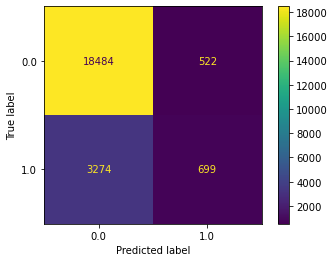

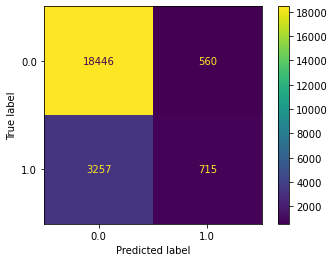

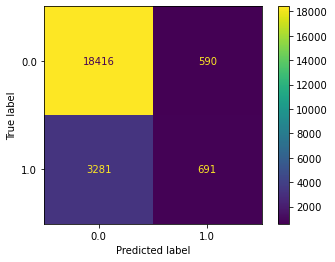

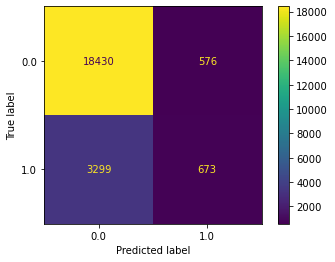

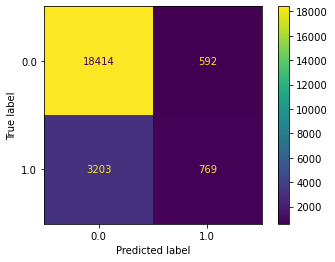

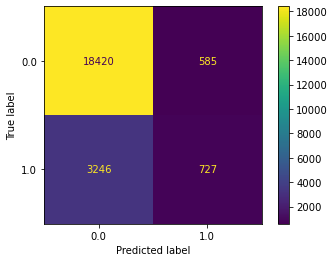

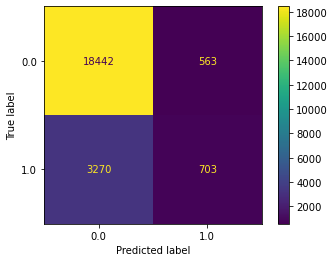

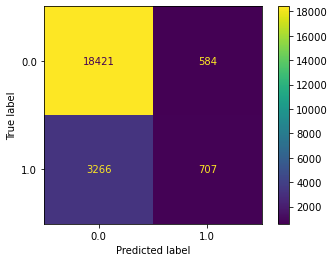

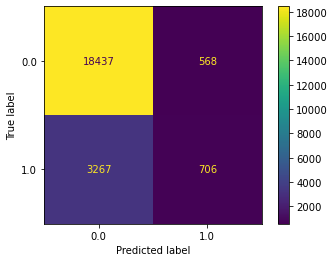

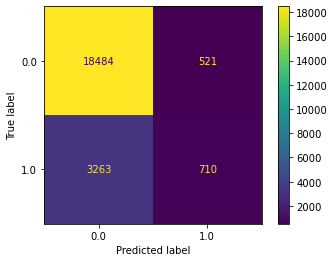

In [41]:
logregbin = LogisticRegression(C=0.01)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in skf.split(x_values_scaled_ss, y_value_binary):
    X_train, X_test = x_values_scaled_ss.iloc[train_index], x_values_scaled_ss.iloc[test_index]
    y_train, y_test = y_value_binary.iloc[train_index], y_value_binary.iloc[test_index]
    logregbin.fit(X_train, y_train)
    logreg_cm = confusion_matrix(y_test, logregbin.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm, display_labels=logregbin.classes_)
    disp.plot()

# 5. Evaluation (binäre Klassifikation) - Machine Learning

# 6. Modelling (Multiclass-Klassifikation) - Machine Learning

## 6.1 Theoretische Auswahl der Modellierungstechnik

In [28]:
# logistische Regression --> binärer Klassifikationsalgorithmus angewendet auf Multiclass (Stichwort One-vs-Rest und One-vs-One)
# Bagging vs Boosting
# binäre vs ... 
# One vs one oder one vs all

# RandomForest für unbalancierte Datensätze (Bagging) --> Link

In [29]:
# LogistischeRegression --> Algortihmus zur Lösung des Optimierungsproblemes --> Solver für Multiclass

##### Quellen

*https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/#:~:text=Bagging%20is%20an%20ensemble%20algorithm,used%20in%20each%20data%20sample.*

*https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/*


## 6.2 Praktische Auswahl der Modellierungstechnik

### 6.2.1 Hypermarameter-Tuning mit GridSearchCV

Um einen ersten Überblick über die Güte und Eignung der gewählten Machine Learning Algorithmen in Bezug auf den Diabetes-Datensatz zu bekommen, wird im Folgenden eine **GridSearchCV** mit den gewählten Methoden und einigen interessanten Parameterkonfigurationen durchgeführt. Bei GridSearchCV handelt es sich um eine **Methode des Hyperparamtertunings**. Sie geht **iterativ** alle möglichen **Parameterkombinationen** durch und ermittelt die, mit der die **besten Ergebnisse** erzielt werden können. GridSearchCV bietet zudem die Möglichkeit, durch den 'cv'-Parameter intern eine **Cross Validation** durchzuführen.

Die x-Werte die der Funktion GridSearchCV übergeben werden wurden vorerst mit dem StandardScaler skaliert. Darüber hinaus wurde der gesamte Datensatz übergeben und nicht nur die wichtigsten Features, um einen ersten Eindruck bezüglich der Ergebnisse auf diesen Datensatz erhalten. Im Anschluss daran werden die besten Modelle noch detaillierter analyisert. Hierbei werden weitere Parameterkombinationen ausprobiert und Sensitivitätsanalysen (z.B. Auswahl eines anderen Scalers, Oversampling und k-Fold vs. StratifiedKFold, Modelling mit nur den wichtigsten Features, usw.) durchgeführt.

##### Erstellung eines verschachtelten Dictionaries mit den gewählten Algorithmen und Parametern

In [30]:
model_params = {
    'logistic_regression': {
        'model': LogisticRegression(multi_class = 'multinomial'),
        'params': {
            'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 10, 100],
            # 1.0 --> bagged trees und 0.3 --> more randomness
            'max_features': ['sqrt', 0.3, 1.0],
            'class_weight': [None, 'balanced']
        }
    },
    'xgboost': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.1, 0.5, 1.0],
            'n_estimators': [1, 10, 100],
            'max_depth': [1, 3, 5]
        }
    },
    'kneighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 10],
            'leaf_size': [10, 30 , 50]
        }
    }
}

##### Initialisierung der GridSearchCV

In [21]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), return_train_score=False, verbose=3)
    clf.fit(x_values_scaled_ss, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df_gridsearch = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df_gridsearch

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................solver=newton-cg;, score=0.847 total time=   4.7s
[CV 2/5] END ..................solver=newton-cg;, score=0.846 total time=   4.1s
[CV 3/5] END ..................solver=newton-cg;, score=0.847 total time=   4.3s
[CV 4/5] END ..................solver=newton-cg;, score=0.846 total time=   4.4s
[CV 5/5] END ..................solver=newton-cg;, score=0.846 total time=   4.2s
[CV 1/5] END ........................solver=sag;, score=0.847 total time=   4.4s
[CV 2/5] END ........................solver=sag;, score=0.846 total time=   4.7s
[CV 3/5] END ........................solver=sag;, score=0.847 total time=   4.4s
[CV 4/5] END ........................solver=sag;, score=0.846 total time=   4.2s
[CV 5/5] END ........................solver=sag;, score=0.846 total time=   4.4s
[CV 1/5] END .......................solver=saga;, score=0.847 total time=   2.6s
[CV 2/5] END .......................solver=saga;,

[CV 1/5] END class_weight=balanced, max_features=0.3, n_estimators=10;, score=0.831 total time=   2.8s
[CV 2/5] END class_weight=balanced, max_features=0.3, n_estimators=10;, score=0.830 total time=   2.7s
[CV 3/5] END class_weight=balanced, max_features=0.3, n_estimators=10;, score=0.831 total time=   2.7s
[CV 4/5] END class_weight=balanced, max_features=0.3, n_estimators=10;, score=0.831 total time=   2.7s
[CV 5/5] END class_weight=balanced, max_features=0.3, n_estimators=10;, score=0.832 total time=   2.6s
[CV 1/5] END class_weight=balanced, max_features=0.3, n_estimators=100;, score=0.838 total time=  26.9s
[CV 2/5] END class_weight=balanced, max_features=0.3, n_estimators=100;, score=0.837 total time=  26.6s
[CV 3/5] END class_weight=balanced, max_features=0.3, n_estimators=100;, score=0.837 total time=  26.8s
[CV 4/5] END class_weight=balanced, max_features=0.3, n_estimators=100;, score=0.838 total time=  28.8s
[CV 5/5] END class_weight=balanced, max_features=0.3, n_estimators=10

[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=1;, score=0.842 total time=   0.7s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=1;, score=0.842 total time=   0.7s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=1;, score=0.842 total time=   0.7s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=1;, score=0.842 total time=   0.7s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=1;, score=0.842 total time=   0.7s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.849 total time=   6.7s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.847 total time=   6.6s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.849 total time=   6.6s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.848 total time=   6.6s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=10;, score=0.848 total time=   6.6s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=100;, s

[CV 5/5] END ......leaf_size=10, n_neighbors=10;, score=0.842 total time= 2.6min
[CV 1/5] END .......leaf_size=30, n_neighbors=1;, score=0.780 total time= 1.5min
[CV 2/5] END .......leaf_size=30, n_neighbors=1;, score=0.776 total time= 1.5min
[CV 3/5] END .......leaf_size=30, n_neighbors=1;, score=0.777 total time= 1.5min
[CV 4/5] END .......leaf_size=30, n_neighbors=1;, score=0.778 total time= 1.5min
[CV 5/5] END .......leaf_size=30, n_neighbors=1;, score=0.777 total time= 1.4min
[CV 1/5] END .......leaf_size=30, n_neighbors=5;, score=0.831 total time= 2.6min
[CV 2/5] END .......leaf_size=30, n_neighbors=5;, score=0.831 total time= 2.6min
[CV 3/5] END .......leaf_size=30, n_neighbors=5;, score=0.830 total time= 2.6min
[CV 4/5] END .......leaf_size=30, n_neighbors=5;, score=0.831 total time= 2.6min
[CV 5/5] END .......leaf_size=30, n_neighbors=5;, score=0.831 total time= 2.6min
[CV 1/5] END ......leaf_size=30, n_neighbors=10;, score=0.841 total time= 2.6min
[CV 2/5] END ......leaf_size

,model,best_score,best_params
0,logistic_regression,0.846452,{'solver': 'newton-cg'}
1,random_forest,0.841974,"{'class_weight': None, 'max_features': 'sqrt',..."
2,xgboost,0.849823,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
3,kneighbors,0.841162,"{'leaf_size': 10, 'n_neighbors': 10}"


### 6.2.2 Auswertung (Hyperparameter-Tuning)

In [25]:
# Was genau ist best_score? Kann und muss dieser für Multiclassklassifikation geändert werden? --> scoring-Parameter?
# Kann das Ergebnis der GridSearchCV oben irgendwie visualisiert werden?

Auf den ersten Blick ist dem Dataframe 'df_gridsearch' ist zu entnehmen, dass mit allen vier gewählten Machine Learning Algorithmen in der besten Parameterkonfiguration ein **ähnlicher 'best_score'** von 0,841162 (KNeighbors) bis 0,849823 (XGBoost) erreicht wurde. Allerdings gibt es noch **weitere Faktoren**, wie z.B. die **Scoring-Time** und die **Fluktuation** der Genauigkeit der Algorithmen **mit unterschiedlichen Parameterkonfigurationen**, die hier betrachtet werden müssen. 

Interessant zu sehen ist hier zum Beispiel, dass die **logistische Regression** in allen insgesamt 20 Fits eine **konstante Performance** ablieferte und stets einen score von 0,846 bei einer **niedrigen Rechenzeit** von unter fünf Sekunden erreichte. Allerdings wurde hier auch **nur** der 'solver'-Parameter **verändert**. Im nächsten Kapitel wird die logistische Regression näher betrachtet und überprüft, ob z.B. mit vorheriger Feature Selection hier noch bessere Ergebnisse erzeugt werden können. 

Beim baumbasierten Algorithmus **RandomForest Classifier** sind die **Beobachtungen** nach den insgesamt 90 Fits etwas **spannender**. Zum einen **variieren die Trainingszeiten** durch die unterschiedlichen Parameterkombinationen mit einer Minimaldauer von 0,2 Sekunden und einer Maximaldauer von 1,1 Minuten stärker, zum anderen wird hierdurch auch der Score relativ **stark beeinflusst**. Vor allem die **Erhöhung** des Parameters **'n_estimators'** scheint hier die Qualität des Modells, bei weiterhin **akzeptablen Trainingszeiten** deutlich zu **verbessern**. In einem weiteren Kapitel wird versucht, die Genauigkeit des RandomForrestClassifiers noch weiter zu erhöhen.

Der ebenfalls baumbasierte **GradientBoostingClassifier** konnte in der GridSearchCV **in allen** insgesamt 135 **Fits** stets einen **Score von über 0,8** erreichen. Obwohl die Trainingszeit dieses Algorithmus **bis zu 1,8 Minuten** erreichte, wird auch dieser Algorithmus in einem späteren Kapitel näher beleuchtet.

Der **KNeighborsClassifier** benötigte in allen insgesamt 45 Fits eine relativ **lange Trainingszeit** von bis zu 2,8 Minuten. Hierbei war der **Score** im Vergleich zu den anderen Algorithmen **nicht besser**. Aufgrunddessen wird von einer detaillierteren Betrachtung dieses Algorithmus in den weiteren Kapiteln vorerst abgesehen. 

##### Zusätzliche Interpretation (Hyperparameter-Tuning mit GridSearchCV)

Bei näherer Betrachtung der Ergebnisse aus der GridSearchCV ist zu erkennen, dass sich die **erreichten Scores und Trainingdauern**, unabhängig von der Wahl des Algorithmus und der Parameter, **innerhalb der einzelnen Cross Validation Splits** nur **geringfügig verändern**. Dies ist ein weiteres Indiz dafür, dass der StratifiedKFold-Split für den vorliegenden unbalancierten Diabetes-Datensatz gut geeignet ist. Darüber hinaus bestätigt sich hierdurch der Schluss der in Kapitel 3.2.3.3 gezogen wurde, dass der gesamte Datensatz auf einmal skaliert werden kann, erneut.

### 6.3 Nähere Betrachtung der logistischen Regression

### 6.3.1 Weitere Optimierungsansätze (logistische Regression)

In [33]:
# muss die Targetvariable OneHotEncoded werden? --> s. zweiter Link in Quellen

Bei näherer Betrachtung der Ergebnisse aus dem vorherigen Kapitel fällt auf, dass die Wahl des **'solver'-Parameters**, also die Wahl des Algorithmus, der zur Lösung des Optimierungsproblems verwendet wird, **keine große Auswirkung auf das Ergebnis** hat. Dennoch konnten mit dem 'lbfgs'-Solver, bei gleichbleibenden Scores, geringere Trainingszeiten erzielt werden. Aufgrund dessen wird die nähere Betrachtung vorerst mit diesem Algorithmus fortgeführt. Als Wert für den **'multi_class'-Parameter** wurde schon im Vorhinein nur **'multinomial** herangezogen, damit der logistische Regression für das vorliegende **Mehrklassenproblem** verwendet werden kann. Zwei **weitere wichtige Parameter** der logistischen Regression, die in der obigen GridSearchCV vorerst noch nicht betrachtet wurden, sind **'C' und 'class_weight'**. 

Letzterer könnte eventuell beim vorliegenden unbalancierten Datensatz eine wichtige Rolle spielen. Aus diesem Grund wird im Folgenden untersucht, wie sich eine **Veränderung des 'class_weight'-Parameters** in Kombination **mit einem normalen KFold-Split** (nicht stratified) auf die Ergebnisse auswirkt.

#### 6.3.1.1 Sensitivitätsanalyse 1: StratifiedKFold vs. 'class_weight'-Parameter und KFoldSplit (logistische Regression)

In [48]:
logreg = LogisticRegression(multi_class='multinomial', class_weight='balanced')
kfcv = KFold(n_splits=5, shuffle=True, random_state=42)
n_scores = cross_val_score(logreg, x_values_scaled_ss, y_value, scoring='accuracy', cv=kfcv)
print(np.mean(n_scores))

0.6459003468937243


##### Erneuter Vergleich mit GridSearchCV (logistische Regression)

Aufgrund der signifikanten Verschlechterung des Ergebnisses der logistischen Regression nach Änderung des 'class_weight'-Parameters, wird sicherheitshalber das alte Modell aus der GridSearchCV in Kapitel 4.2.1 nochmals überprüft, um auszuschließen, dass das Modelling bzw. die GridSearchCV falsch implementiert wurden.  

In [50]:
logreg = LogisticRegression(multi_class='multinomial')
kfcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_scores = cross_val_score(logreg, x_values_scaled_ss, y_value, scoring='accuracy', cv=kfcv)
print(np.mean(n_scores))

0.8464522232734153


Es ist zu erkennen, dass sich hier das gleiche Ergebnis ergibt, wie bei bei der obigen GridSearchCV. So konnte ausgeschlossen werden, dass die GridSearchCV bzw. das tatsächliche Modelling in diesem Kapitel falsch bzw. unterschiedlich implementiert wurden. Die Werte des Modellings außerhalb der GridSearchCV sind somit auch wirklich mit den anderen Werten vergleichbar. 

##### Interpretation (Sensitivitätsanalyse 1 - Logistische Regression)

Es ist zu erkennen, dass die Variante, die Unbalanciertheit des Datensatzes durch den 'class_weight'-Parameter der logistischen Regression in sklearn auszugleichen und das anschließende Training mit einem normalen KFold-Split durchzuführen, deutlich schlechtere Ergebnisse erzielt, als der StratifiedKFold-Split, weshalb dieser Ansatz verworfen wird. 

#### 6.3.1.2 Veränderung des C-Wertes (logistische Regression)

Ein weiterer wichtiger Parameter der logistischen Regression ist die Festlegung des Strafterms, der zu den einzelnen Koeffizienten der Regressionsgleichung hinzuaddiert wird. In sklearn kann dieser beeinflusst werden durch die Parameter 'penalty' und 'C'. Da die 'solver', die für die Multiclassklassifikation herangezogen werden können (‘newton-cg’, ‘sag’, ‘saga’ und ‘lbfgs’) nur in Kombination mit dem l2-Strafterm arbeiten können, ist die Wahl dieses Parameters hinfällig. Der 'C'-Parameter bestimmt die Stärke der Regulierung mittels der Strafterme. Er kann Werte von 0.0 bis 1.0 annehmen, wobei 1.0 für eine schwache Regulierung durch die Strafterme steht und 0.0 für eine starke Regulierung. 

In [55]:
logreg = LogisticRegression(multi_class='multinomial')
kfcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_scores = cross_val_score(logreg, x_values_scaled_ss, y_value, scoring='f1_weighted', cv=kfcv)
print(np.mean(n_scores))

0.8078164959914911


##### Quellen

*https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html*

*https://machinelearningmastery.com/multinomial-logistic-regression-with-python/*

##### Quellen zum Code
*https://www.youtube.com/watch?v=HdlDYng8g9s*

##### weitere Quellen

*https://machinelearningmastery.com/types-of-classification-in-machine-learning/*

allgemeine Modellerklärung

*https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6*

*https://towardsdatascience.com/random-forest-explained-7eae084f3ebe*

RandomForestClassifier (Parameter)

*https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d*

*https://scikit-learn.org/stable/modules/ensemble.html#parameters* (1.11.2.3 Parameters)

*https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html*

XGBoost (Parameter)

*https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368*

*https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76*

KNN (Parameter)

*https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76*

*https://medium.com/analytics-vidhya/summary-of-knn-algorithm-when-used-for-classification-4934a1040983*

*https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f*

*https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-knn-4c0de485baf6*

# 7. Evaluation (Multiclassklassifikation) - Machine Learning

- Balanced Accuracy Score
- Cohen Kappa Score
- Confusion Matrix
- Hinge Loss
- Matthews corrcoef
- Roc_Auc_Score
- Top K Accuray

--> VISUALISIERUNGEN!

##### Quellen

*https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring*

# 7.1 Classification Report

In [ ]:
target_names = ['Healthy', 'Prediabetes', 'Diabetes']

print(classification_report(y_test_tts, clf_dtc.predict(x_test_tts), target_names = target_names))

## 7.2 f1 Score

In [ ]:
# SVC
# print(f1_score(y_test_tts, clf_svm.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))

# Decision Tree Classifier
# print(f1_score(y_test_tts, clf_dtc.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))

# Random Forrest Classifier
# print(f1_score(y_test_tts, clf_rfc.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))
# after Feature Selection
# print(f1_score(y_test_tts_sel, clf_rfc_sel.predict(x_test_tts_sel), average = None, labels = [0.0,1.0,2.0]))

# 8. Modelling - Deep Learning

In [18]:
model = tf.keras.Sequential()
# Anzahl Input
model.add(tf.keras.Input(shape=(4,)))
model.add(tf.keras.layers.Dense(2, activation="relu"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


##### Quellen 

*https://towardsdatascience.com/beginners-guide-to-deep-learning-with-tensorflow-ca85969b2f2*

*https://towardsdatascience.com/a-simple-introduction-to-tensorflow-d992eb2e3dbb*

# 9. Evaluation - Deep Learning

# 10. Evalution

# Quellenverzeichnis

##### Quellen (doppelte Zeilen entfernen)
*https://deepchecks.com/what-is-data-cleaning/*

##### Quellen (Feature Scaling)
*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*

*https://scikit-learn.org/stable/modules/cross_validation.html*